In [220]:
#permet d'afficher les différente colonne présent dans le fichier des metadata en suprimant les columns redondantes
liste=[ 'atcdcrohn', 'micianteriorite_chir_1',
       'micidate_chir1', 'micianteriorite_chir_2', 'micidate_chir2',
       'micianteriorite_chir_3', 'micidate_chir3', 'micianteriorite_chir_4',
       'micidate_chir4', 'micidate_debut_imu', 'micidate_arret_imu',
       'micidate_debut_purinethol', 'micidate_arret_purinethol',
       'micidate_debut_mtx', 'micidate_arret_mtx', 'micidate_debut_humira',
       'micidate_arret_humira', 'micidate_debut_ustekinumab',
       'micidate_arret_ustekinumab', 'micidate_debut_vedolizumab']

for i in liste:
    del (metadata[i])
metadata.columns


KeyError: 'atcdcrohn'

In [23]:
#importation des different library
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importation des library de mehtode de visualisation
from sklearn.manifold import Isomap,locally_linear_embedding,MDS

#importation des library de clustering 
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy.cluster.hierarchy import fcluster
import scipy.stats as st
#library auto-encoder
from torch import nn
from torch.autograd import Variable
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau 

#library ca
import prince 
from sklearn import preprocessing

#importation des library pour les differente methode de scale 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


In [2]:
#faire une CAH sur le jeu total de philr 
def scaling(data, methode= None):
    index = data.index 
    colone= data.columns
    if not methode:
        return data
    data=data.values
    if methode == "StandardScaler" :
        data = StandardScaler().fit_transform(data)

    if methode == "MinMaxScaler" :
        data = MinMaxScaler().fit(data)

    if methode == "MaxAbsScaler" :
        data = MaxAbsScaler().fit_transform(data)

    if methode == "RobustScaler" :
        data = RobustScaler(quantile_range=(25, 75)).fit_transform(data)

    if methode == "PowerTransformer_yj" :
        data = PowerTransformer(method='yeo-johnson').fit_transform(data)

    if methode == "PowerTransformer_b_c" :
        data = PowerTransformer(method='box-cox').fit_transform(data)
    data=pd.DataFrame(data, index = index, columns = colone)
    return data


In [3]:
#creation d'une classe afin de mettre en place différente techique de reduction de dimension,ainsi que de visualisation 
class reduction_de_dimension():
    def __init__(self,
                methode,
                visualisation=True,
                nbre_dimension=2):
        self.methode=methode
        self.nbre_dimension=nbre_dimension
        self.fit=None
        self.data=None
        self.label_data=None
    def mise_en_place(self,data,label_data,**kwargs):
        self.data=data
        self.label_data=label_data
        if self.methode==locally_linear_embedding:
            X_r, err = locally_linear_embedding(data, n_neighbors=12, out_dim=self.nbre_dimension)
            self.fit=X_r
        if self.nbre_dimension ==None:
            model = self.methode(**kwargs)
            
        else:
            model = self.methode(n_components=self.nbre_dimension,**kwargs)
        self.fit = model.fit_transform(data)
    def get_fit(self):
        data=pd.DataFrame({"axe"+str(i):self.fit[:,i] for i in range(self.fit.shape[1]) })
        data.set_index(self.data.index,inplace=True )
        
        return data
        
    def plot(self,label=None):
        if label:
            nbre_color=len(self.label_data[label].unique())
        #on regarde si il y a des valeurs na
            if self.label_data[label].isna().any():
                nbre_color-=1
        else:
            nbre_color=0
        
        if self.nbre_dimension==2:
            data=pd.DataFrame({"axe1":self.fit[:,0],"axe2":self.fit[:,1] })
            data.set_index(self.data.index,inplace=True )
            data.index.name="echantillon"
            data.reset_index(inplace=True)
            
            if not self.label_data.empty:
                self.label_data=pd.merge(data,self.label_data,on="echantillon")
            else:
                self.label_data=data
            plt.figure()
            sns.scatterplot(
            x="axe1", y="axe2",
            palette=sns.color_palette("Set1",n_colors=nbre_color ),
            hue=label,
            data=self.label_data,
            legend="full",
            alpha=1
            )
            
        if self.nbre_dimension==3:
            data=pd.DataFrame({"axe1":self.fit[:,0],"axe2":self.fit[:,1],'axe3':self.fit[:, 2] })
            print(data)
            data.set_index(self.data.index,inplace=True )
            data.index.name="echantillon"
            data.reset_index(inplace=True)
            if not self.label_data.empty:
                self.label_data=pd.merge(data,self.label_data,on="echantillon")
            if not label:
                
                ax = plt.figure().gca(projection='3d')
                ax.scatter(
                    xs=data["axe1"], 
                    ys=data["axe2"], 
                    zs=data["axe3"], 
                    cmap='tab10'
                )
                ax.set_xlabel('axe1')
                ax.set_ylabel('axe2')
                ax.set_zlabel('axe3')
                plt.show()
            else:
                ax = plt.figure(figsize=(16,10)).gca(projection='3d')
                print(self.label_data[label].unique())
                for i in self.label_data[label].unique():
                    print(self.label_data[label]==i)
                    ax.scatter(
                    xs=data["axe1"].loc[self.label_data[label]==i], 
                    ys=data["axe2"].loc[self.label_data[label]==i], 
                    zs=data["axe3"].loc[self.label_data[label]==i], 
                    cmap='tab10',
                    label=i
                )
                plt.legend()
#es ce qu'on peut observer des groupes de patient qui ont des caractéristique clinique identique

In [4]:
#fonction pris du site https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [5]:
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)


    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, data in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            data=Variable(data).to(cuda0)
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, data)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
        
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            data=Variable(data).to(cuda0)
            output = model(data)
            # calculate the loss
            loss = criterion(output, data)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        scheduler.step(valid_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [6]:
#creation de notre couche de neurone qui représente les interactions entre le microbiote
#representation pytorch de GEFDN
import torch
loss = nn.BCELoss()
class couche_interaction(torch.nn.Module):
    def __init__(self,
        in_dim,
        hid,
        matrice_ajancement=None,
        *args,
        **kwargs):
        super(couche_interaction, self).__init__(*args, **kwargs)
        if isinstance(matrice_ajancement,np.ndarray):
            matrice_ajancement=torch.from_numpy(b).float()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.linear1 = nn.Linear(in_dim,hid)
        self.linear1.weight = torch.nn.Parameter(torch.randn(in_dim,hid))
        self.linear1.bias = torch.nn.Parameter(torch.randn(hid))
        self.matrice_ajancement=matrice_ajancement
    def forward(self, x):
        self.linear1.weight.data.mul_(self.matrice_ajancement)
        x = self.linear1(x)
        return x


In [7]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(61, 42),
            nn.ReLU(True),
            nn.Linear(42, 32))
        self.decoder = nn.Sequential(
            nn.Linear(32, 42),
            nn.ReLU(True),
            nn.Linear(42, 61))

    def forward(self, x,encodeur=False,decodeur=False):
        if encodeur:
            x = self.encoder(x)
            return x
        elif decodeur:
            x = self.decoder(x)
            return x
        else:
            x = self.encoder(x)
            x = self.decoder(x)
            return x


In [8]:
#fonction permettant le traitement des different metadata

#observation du nombre de traitement différent qu'a pris un patient
def count_medicament(row):
    nbre_med=0
    if row["traitement_imu"] ==1:
        nbre_med+=1
    if row["traitement_purinethol"] ==1:
        nbre_med+=1
    if row["traitement_humira"] ==1:
        nbre_med+=1
    if row["traitement_mtx"] ==1:
        nbre_med+=1
    if row["traitement_ustekinumab"] ==1:
        nbre_med+=1
    if row["traitement_vedolizumab"] ==1:
        nbre_med+=1
    return nbre_med


In [9]:
#path des different document
data="C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\document_inportant\\Donne_otu_normalise.csv"

#ouverture des different documens t
philr=pd.read_csv(data)
metadata=pd.read_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\document_inportant\\metadata.csv")
alpha_diversite=pd.read_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\document_inportant\\alpha_mesure.csv")
print(philr)

#traitement des metadata
metadata["nbre_medicament"]=metadata.apply(count_medicament,axis=1)
alpha_diversite.rename(columns={"Unnamed: 0":"echantillon"},inplace=True)
alpha_diversite['echantillon']=alpha_diversite['echantillon'].apply(lambda x: x[1:])
#creatin de la colonne patient_symptomatique
metadata.replace({"CROHN (pas suivi CHU)":"crohn","RCH":"autre","n":"autre","SII":"autre","II":"autre","JULIEN":"autre","FISTULE":"autre","HEMORROIDE POSSIBLE CROHN":"autre","BEHCET":"autre"},inplace=True)
metadata.replace({"n":"autre"},inplace=True)
liste=["atcdcrohn","sexe_y","score","_date","hb_uveite","mici_extension_rch","montreal_âge","duree_vedolizumab","difference_date"]
metadata["micidiagostic_montreal_b"].replace({"E3": "L3", "E2": "L2","E1": "L1"},inplace=True) 
metadata["micidiagostic_montreal_l"].replace({"E3": "L3", "E2": "L2","E1": "L1"},inplace=True) 
metadata["montreal_l4"].replace({"non": "0"},inplace=True) 
metadata["montreal_p"].replace({"NON": "0","OUI":'1'},inplace=True) 
metadata["maladie"].replace({"CROHN": "crohn","Crohn":"crohn",'JULIEN ':"autre"},inplace=True) 

for i in liste:
    del(metadata[i])
#hyper parametre
label="patient_symp"

#on garde seulement les otu qui ont un metadata
#philr.rename(columns={"Unnamed: 0":"echantillon"}, inplace=True)
#table_philr=pd.merge(metadata[["echantillon"]],philr,on="echantillon")
#table_philr.set_index("echantillon",inplace=True)
#table_philr
metadata=pd.merge(alpha_diversite,metadata,on="echantillon")

#appliqué une normalisation des variance 
#dataframe = scaling(table_philr,methode="StandardScaler") 
#description du dataframe 


       Unnamed: 0  Cluster_161  Cluster_24  Cluster_26  Cluster_20  \
0    100_S48_L001     2.750781   -1.774087    2.750781    2.750781   
1    101_S49_L001     1.679385   -2.086225    0.877038    4.364178   
2    102_S50_L001     4.880316    6.957169   -0.039665    6.455097   
3    103_S51_L001     5.502674   -3.147990   -3.047210    7.673044   
4    104_S52_L001     5.791739   -2.816400   -2.715621    5.389712   
..            ...          ...         ...         ...         ...   
351   96_S44_L001     4.807234   -3.087875   -0.146243    3.399535   
352   97_S45_L001    -1.644171   -1.558591    2.597374    0.112467   
353   98_S46_L001     4.694162   -2.872364    1.762968    7.202599   
354   99_S47_L001     3.541221   -2.919136   -0.640829    4.985893   
355     9_S9_L001    -1.765286    0.719392    3.552605    0.719392   

     Cluster_23  Cluster_191  Cluster_560  Cluster_462  Cluster_463  ...  \
0      2.750781    -2.030533    -1.758571    -1.408720    -1.859625  ...   
1      

KeyError: 'score'

In [10]:
metadata

echantillon micianteriorite_chir_1 micianteriorite_chir_2  \
0     21_S21_L001                  aucun                  aucun   
1    155_S39_L001                  aucun                  aucun   
2     118_S2_L001    chirurgie_perineale    chirurgie_perineale   
3     186_S6_L001                  aucun                  aucun   
4    369_S61_L001      drainage_fistulRV           fistulotomie   
..            ...                    ...                    ...   
357  325_S17_L001                    NaN                    NaN   
358  166_S50_L001                    NaN                    NaN   
359  207_S27_L001                    NaN                    NaN   
360  223_S43_L001                    NaN                    NaN   
361  206_S26_L001                    NaN                    NaN   

    micianteriorite_chir_3 micianteriorite_chir_4 micidiagostic_montreal_a  \
0                    aucun                  aucun                       A1   
1                    aucun                  aucun                       A2   
2      chirurgie_perineale    chirurgie_périnéale                       A2   
3                    aucun                  aucun                       A1   
4                      NaN                  aucun                       A2   
..                     ...                    ...                      ...   
357                    NaN                    NaN                      NaN   
358                    NaN                    NaN                      NaN   
359                    NaN                    NaN                      NaN   
360                    NaN                    NaN                      NaN   
361                    NaN                    NaN                      NaN   

    micidiagostic_montreal_b micidiagostic_montreal_l  \
0                         B1                    L3+L4   
1                        pB1                       L1   
2                         B1                       L3   
3                        pB3                       L3   
4                         B1                       L3   
..                       ...                      ...   
357                      NaN                      NaN   
358                      NaN                      NaN   
359                      NaN                      NaN   
360                      NaN                      NaN   
361                      NaN                      NaN   

    micievolution_montreal_b  micievolution_montreal_b_date  ... antitnf_mtf  \
0                        NaN                            0.0  ...         1.0   
1                        NaN                            0.0  ...         1.0   
2                        NaN                            0.0  ...         2.0   
3                        NaN                            0.0  ...         2.0   
4                        pB1                            1.0  ...         2.0   
..                       ...                            ...  ...         ...   
357                      NaN                            NaN  ...         NaN   
358                      NaN                            NaN  ...         NaN   
359                      NaN                            NaN  ...         NaN   
360                      NaN                            NaN  ...         NaN   
361                      NaN                            NaN  ...         NaN   

    tnfalpha  nbre_medoc_mt            difference_date  calprotectine  \
0        0.0            2.0  0 days 00:00:00.000000000           14.0   
1        0.0            0.0  6 days 00:00:00.000000000          138.0   
2        0.0            0.0  8 days 00:00:00.000000000          238.0   
3        1.0            2.0  0 days 00:00:00.000000000           10.0   
4        0.0            0.0  0 days 00:00:00.000000000          480.0   
..       ...            ...                        ...            ...   
357      NaN            NaN                        NaN            NaN   
358      NaN            NaN       

In [11]:
#metadata=pd.merge(alpha_diversite,metadata,on="echantillon")
metadata

echantillon micianteriorite_chir_1 micianteriorite_chir_2  \
0     21_S21_L001                  aucun                  aucun   
1    155_S39_L001                  aucun                  aucun   
2     118_S2_L001    chirurgie_perineale    chirurgie_perineale   
3     186_S6_L001                  aucun                  aucun   
4    369_S61_L001      drainage_fistulRV           fistulotomie   
..            ...                    ...                    ...   
357  325_S17_L001                    NaN                    NaN   
358  166_S50_L001                    NaN                    NaN   
359  207_S27_L001                    NaN                    NaN   
360  223_S43_L001                    NaN                    NaN   
361  206_S26_L001                    NaN                    NaN   

    micianteriorite_chir_3 micianteriorite_chir_4 micidiagostic_montreal_a  \
0                    aucun                  aucun                       A1   
1                    aucun                  aucun                       A2   
2      chirurgie_perineale    chirurgie_périnéale                       A2   
3                    aucun                  aucun                       A1   
4                      NaN                  aucun                       A2   
..                     ...                    ...                      ...   
357                    NaN                    NaN                      NaN   
358                    NaN                    NaN                      NaN   
359                    NaN                    NaN                      NaN   
360                    NaN                    NaN                      NaN   
361                    NaN                    NaN                      NaN   

    micidiagostic_montreal_b micidiagostic_montreal_l  \
0                         B1                    L3+L4   
1                        pB1                       L1   
2                         B1                       L3   
3                        pB3                       L3   
4                         B1                       L3   
..                       ...                      ...   
357                      NaN                      NaN   
358                      NaN                      NaN   
359                      NaN                      NaN   
360                      NaN                      NaN   
361                      NaN                      NaN   

    micievolution_montreal_b  micievolution_montreal_b_date  ... antitnf_mtf  \
0                        NaN                            0.0  ...         1.0   
1                        NaN                            0.0  ...         1.0   
2                        NaN                            0.0  ...         2.0   
3                        NaN                            0.0  ...         2.0   
4                        pB1                            1.0  ...         2.0   
..                       ...                            ...  ...         ...   
357                      NaN                            NaN  ...         NaN   
358                      NaN                            NaN  ...         NaN   
359                      NaN                            NaN  ...         NaN   
360                      NaN                            NaN  ...         NaN   
361                      NaN                            NaN  ...         NaN   

    tnfalpha  nbre_medoc_mt            difference_date  calprotectine  \
0        0.0            2.0  0 days 00:00:00.000000000           14.0   
1        0.0            0.0  6 days 00:00:00.000000000          138.0   
2        0.0            0.0  8 days 00:00:00.000000000          238.0   
3        1.0            2.0  0 days 00:00:00.000000000           10.0   
4        0.0            0.0  0 days 00:00:00.000000000          480.0   
..       ...            ...                        ...            ...   
357      NaN            NaN                        NaN            NaN   
358      NaN            NaN       

In [12]:
pd.options.display.max_rows=300
pd.options.display.max_columns=300
philr
philr.rename(columns={"Unnamed: 0":"echantillon"}, inplace=True)
philr=pd.merge(metadata[["echantillon"]],philr,on="echantillon")
philr.set_index("echantillon",inplace=True)
dataframe = scaling(philr,methode="StandardScaler")

In [13]:
dataframe

Cluster_161  Cluster_24  Cluster_26  Cluster_20  Cluster_23  \
echantillon                                                                 
21_S21_L001      1.031806    1.083992   -1.463175    0.777804    1.564844   
155_S39_L001     0.981673   -0.684381    0.018348    0.714872    0.862847   
118_S2_L001     -1.253140   -0.723881    0.325544    0.381633   -0.877027   
186_S6_L001     -0.864232    0.306952    1.521947   -1.431648   -0.537679   
369_S61_L001     0.999394    2.682706    0.777696   -1.372704    0.751897   
...                   ...         ...         ...         ...         ...   
325_S17_L001     0.420393    0.360782   -0.491062    0.704453   -0.216309   
166_S50_L001     1.364428   -0.402276    1.146791    0.999294   -1.498600   
207_S27_L001     0.087834   -0.717241    0.117509    0.398938    1.294876   
223_S43_L001     0.097941   -0.853259   -0.307656    0.435754    1.053555   
206_S26_L001     1.203873   -0.717074   -0.412170    0.155134    0.708463   

              Cluster_191  Cluster_560  Cluster_462  Cluster_463  Cluster_305  \
echantillon                                                                     
21_S21_L001     -0.757948    -0.768009    -0.426324    -0.711112    -0.476793   
155_S39_L001    -0.683048     0.008761    -0.890592    -1.202588    -0.745095   
118_S2_L001      2.293572     1.592738    -0.455107     0.800436    -0.176919   
186_S6_L001      1.943689    -0.074632     0.357122     0.118247     0.882793   
369_S61_L001     3.123103     1.633928    -0.496436    -0.785333    -0.230841   
...                   ...          ...          ...          ...          ...   
325_S17_L001    -0.525919    -0.365873     0.028048     1.317616    -0.119295   
166_S50_L001     0.071103     0.765356    -0.447674    -0.733713    -0.167221   
207_S27_L001    -0.446244    -0.688508    -0.336496    -0.616019    -0.022167   
223_S43_L001    -0.627639    -1.015511    -0.705976    -1.007153    -0.504227   
206_S26_L001    -0.446022     0.095913    -0.482576    -0.770660    -0.212757   

              Cluster_303  Cluster_302  Cluster_263  Cluster_264  Cluster_267  \
echantillon                                                                     
21_S21_L001     -1.052291    -0.665257     1.064183    -0.618967     0.628000   
155_S39_L001     0.093935    -0.669249     2.121882     0.343249    -0.583469   
118_S2_L001     -0.727063    -0.178070    -0.771102    -0.372842    -0.918922   
186_S6_L001     -0.242081     0.339645    -0.332908     0.505155    -0.120213   
369_S61_L001     0.452119    -0.224685    -0.398309    -0.417517    -0.959563   
...                   ...          ...          ...          ...          ...   
325_S17_L001    -0.803117    -0.356206    -0.839818     0.810795    -0.862145   
166_S50_L001    -0.721820    -0.169686    -0.766365    -0.364806    -0.911613   
207_S27_L001    -0.717554    -0.044290    -0.762510    -0.244626    -0.802285   
223_S43_L001     0.336833    -0.461023    -0.938516    -0.644024     0.350040   
206_S26_L001    -0.189897    -0.209052    -0.762294    -0.402534    -0.945934   

              Cluster_417  Cluster_418  Cluster_139  Cluster_131  Cluster_136  \
echantillon                                                                     
21_S21_L001     -0.839598    -0.886581    -1.095445     0.267524     0.028940   
155_S39_L001    -0.388986     1.350889    -1.012466     1.234767    -1.059614   
118_S2_L001      2.916955     0.759837     0.936374     0.504816    -1.086674   
186_S6_L001     -0.114656    -0.103100    -0.259608    -1.084164    -0.727745   
369_S61_L001     1.859321    -0.956696     0.872582    -1.333202     1.459370   
...                   ...          ...          ...          ...          ...   
325_S17_L001     0.466769    -0.432189    -0.838389     0.834979    -0.437201   
166_S50_L001    -0.859354    -0.907932     1.258006     1.454423     1.703013   
207_S27_L001    -0.756478     2.294075    -0.166570    -1.019074     0.559088   
223_S43_L001 

In [14]:
dataframe

Cluster_161  Cluster_24  Cluster_26  Cluster_20  Cluster_23  \
echantillon                                                                 
21_S21_L001      1.031806    1.083992   -1.463175    0.777804    1.564844   
155_S39_L001     0.981673   -0.684381    0.018348    0.714872    0.862847   
118_S2_L001     -1.253140   -0.723881    0.325544    0.381633   -0.877027   
186_S6_L001     -0.864232    0.306952    1.521947   -1.431648   -0.537679   
369_S61_L001     0.999394    2.682706    0.777696   -1.372704    0.751897   
...                   ...         ...         ...         ...         ...   
325_S17_L001     0.420393    0.360782   -0.491062    0.704453   -0.216309   
166_S50_L001     1.364428   -0.402276    1.146791    0.999294   -1.498600   
207_S27_L001     0.087834   -0.717241    0.117509    0.398938    1.294876   
223_S43_L001     0.097941   -0.853259   -0.307656    0.435754    1.053555   
206_S26_L001     1.203873   -0.717074   -0.412170    0.155134    0.708463   

              Cluster_191  Cluster_560  Cluster_462  Cluster_463  Cluster_305  \
echantillon                                                                     
21_S21_L001     -0.757948    -0.768009    -0.426324    -0.711112    -0.476793   
155_S39_L001    -0.683048     0.008761    -0.890592    -1.202588    -0.745095   
118_S2_L001      2.293572     1.592738    -0.455107     0.800436    -0.176919   
186_S6_L001      1.943689    -0.074632     0.357122     0.118247     0.882793   
369_S61_L001     3.123103     1.633928    -0.496436    -0.785333    -0.230841   
...                   ...          ...          ...          ...          ...   
325_S17_L001    -0.525919    -0.365873     0.028048     1.317616    -0.119295   
166_S50_L001     0.071103     0.765356    -0.447674    -0.733713    -0.167221   
207_S27_L001    -0.446244    -0.688508    -0.336496    -0.616019    -0.022167   
223_S43_L001    -0.627639    -1.015511    -0.705976    -1.007153    -0.504227   
206_S26_L001    -0.446022     0.095913    -0.482576    -0.770660    -0.212757   

              Cluster_303  Cluster_302  Cluster_263  Cluster_264  Cluster_267  \
echantillon                                                                     
21_S21_L001     -1.052291    -0.665257     1.064183    -0.618967     0.628000   
155_S39_L001     0.093935    -0.669249     2.121882     0.343249    -0.583469   
118_S2_L001     -0.727063    -0.178070    -0.771102    -0.372842    -0.918922   
186_S6_L001     -0.242081     0.339645    -0.332908     0.505155    -0.120213   
369_S61_L001     0.452119    -0.224685    -0.398309    -0.417517    -0.959563   
...                   ...          ...          ...          ...          ...   
325_S17_L001    -0.803117    -0.356206    -0.839818     0.810795    -0.862145   
166_S50_L001    -0.721820    -0.169686    -0.766365    -0.364806    -0.911613   
207_S27_L001    -0.717554    -0.044290    -0.762510    -0.244626    -0.802285   
223_S43_L001     0.336833    -0.461023    -0.938516    -0.644024     0.350040   
206_S26_L001    -0.189897    -0.209052    -0.762294    -0.402534    -0.945934   

              Cluster_417  Cluster_418  Cluster_139  Cluster_131  Cluster_136  \
echantillon                                                                     
21_S21_L001     -0.839598    -0.886581    -1.095445     0.267524     0.028940   
155_S39_L001    -0.388986     1.350889    -1.012466     1.234767    -1.059614   
118_S2_L001      2.916955     0.759837     0.936374     0.504816    -1.086674   
186_S6_L001     -0.114656    -0.103100    -0.259608    -1.084164    -0.727745   
369_S61_L001     1.859321    -0.956696     0.872582    -1.333202     1.459370   
...                   ...          ...          ...          ...          ...   
325_S17_L001     0.466769    -0.432189    -0.838389     0.834979    -0.437201   
166_S50_L001    -0.859354    -0.907932     1.258006     1.454423     1.703013   
207_S27_L001    -0.756478     2.294075    -0.166570    -1.019074     0.559088   
223_S43_L001 

In [15]:
#for i,v in enumerate(metadata.dtypes):
#    print(metadata.columns[i],v)
##metadata[metadata.columns[i]]=pd.Categorical(rec(visapremv,"ENDET","E0","E1"),ordered=False)
#for i in metadata.columns:
#    print(metadata[i].value_counts())
#
#metadata.to_csv("C:\\Users\\franc\\Documents\\stage\\metadata.csv")
metadata.describe()


micievolution_montreal_b_date          hb    hb_abces    hb_aphte  \
count                     259.000000  228.000000  204.000000  203.000000   
mean                        0.123552    2.894737    0.009804    0.019704   
std                         0.329707    3.514272    0.098771    0.139326   
min                         0.000000    0.000000    0.000000    0.000000   
25%                         0.000000    0.000000    0.000000    0.000000   
50%                         0.000000    1.000000    0.000000    0.000000   
75%                         0.000000    5.000000    0.000000    0.000000   
max                         1.000000   16.000000    1.000000    1.000000   

       hb_arthralgies  hb_bien_être  hb_douleurs  hb_erytheme_noueux  \
count      204.000000    227.000000   226.000000          203.000000   
mean         0.088235      0.484581     0.610619            0.014778   
std          0.284335      0.783390     0.804804            0.120963   
min          0.000000      0.000000     0.000000            0.000000   
25%          0.000000      0.000000     0.000000            0.000000   
50%          0.000000      0.000000     0.000000            0.000000   
75%          0.000000      1.000000     1.000000            0.000000   
max          1.000000      4.000000     3.000000            1.000000   

       hb_fissure  hb_fistule    hb_masse  hb_pyoderma  hb_selles_liquides  \
count  205.000000  205.000000  208.000000        203.0          201.000000   
mean     0.039024    0.102439    0.057692          0.0            1.711443   
std      0.194127    0.303967    0.271938          0.0            2.529094   
min      0.000000    0.000000    0.000000          0.0            0.000000   
25%      0.000000    0.000000    0.000000          0.0            0.000000   
50%      0.000000    0.000000    0.000000          0.0            0.000000   
75%      0.000000    0.000000    0.000000          0.0            3.000000   
max      1.000000    1.000000    2.000000          0.0           10.000000   

       hb_uveite  montreal_âge        pdai  pdai_douleurs  pdai_ecoulement  \
count      201.0         259.0  223.000000     218.000000       218.000000   
mean         0.0           0.0    0.816143       0.220183         0.188073   
std          0.0           0.0    2.151327       0.641970         0.540050   
min          0.0           0.0    0.000000       0.000000         0.000000   
25%          0.0           0.0    0.000000       0.000000         0.000000   
50%          0.0           0.0    0.000000       0.000000         0.000000   
75%          0.0           0.0    0.000000       0.000000         0.000000   
max          0.0           0.0   10.000000       3.000000         3.000000   

       pdai_induration    pdai_sex  pdai_type_lap    poids_kg     bio_crp  \
count       211.000000  213.000000     212.000000  225.000000  115.000000   
mean          0.047393    0.136150       0.254717   67.544444   22.077391   
std           0.253791    0.570715       0.716248   14.143012   79.049763   
min           0.000000    0.000000       0.000000   40.000000    0.000000   
25%           0.000000    0.000000       0.000000   56.000000    1.000000   
50%           0.000000    0.000000       0.000000   66.000000    4.700000   
75%           0.000000    0.000000       0.000000   75.000000   18.000000   
max           2.000000    4.000000       4.000000  106.000000  823.000000   

       bio_infliximabemie  nombre_op_chir  traitement_imu    duree_imu  \
count            6.000000      259.000000      259.000000   259.000000   
mean            16.633333        0.810811        0.648649  1291.853282   
std             13.234148        1.147511        0.478317  1931.585861   
min              2.400000        0.000000        0.000000 -1081.000000   
25%              6.350000        0.000000        0.000000     0.000000   
50%             17.200000        0.000000        1.000000   183.000000   
75%             21.000000        1.000000        1.0000

In [16]:
bob=pd.merge(bob,metadata[["echantillon", 'hb', 'hb_abces',
       'hb_aphte', 'hb_arthralgies', 'hb_bien_être', 'hb_douleurs',
       'hb_erytheme_noueux', 'hb_fissure', 'hb_fistule', 'hb_masse',
       'hb_pyoderma', 'hb_selles_liquides', 'hb_uveite', 'hughes_fissure',
       'hughes_fistule', 'hughes_stenose']],on= "echantillon")
bob.dropna()
bob

NameError: name 'bob' is not defined

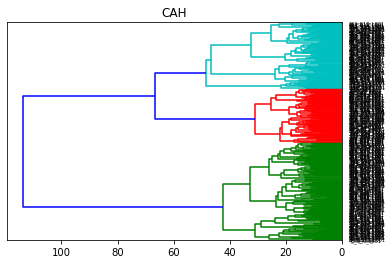

     echantillon
1    21_S21_L001
1    249_S5_L001
1   287_S43_L001
1    37_S35_L001
1   229_S49_L001
..           ...
3   203_S23_L001
3   282_S38_L001
3    123_S7_L001
3   254_S10_L001
3      5_S5_L001

[346 rows x 1 columns]


In [20]:
%matplotlib inline
#creation d'une instance pour la classification pour les donner sans traitement, et avec traitement de l'auto-encoder 
donne_reel=classification_automatique(dataframe)
#donne_traiter=classification_automatique(df)
#utilisation de la methode de classification, il faut utiliser le decoupage_hauteur afin de definir les groupes 
donne_reel_groupe=donne_reel.CAH(decoupage_hauteur=60,color_threshold=60)
#donne_traiter_groupe=donne_traiter.CAH(decoupage_hauteur=8,color_threshold=8)
print(donne_reel_groupe)
#print(donne_traiter_groupe)
#pd.crosstab(donne_reel_groupe,donne_traiter_groupe,rownames=donne_reel_groupe.index,colnames=donne_traiter_groupe.index)
label="echantillon"
#afficher la composition des labels par groupes 
#for i in  donne_reel_groupe.index.unique():
#    print(donne_reel_groupe.loc[i]["echantillon"].value_counts())
#print("#########################################################")
#for i in  donne_traiter_groupe.index.unique():
#    print(donne_traiter_groupe.loc[i]["echantillon"].value_counts())

#utiliser la ligne dessous si jamais la colonne echantillon n'est pas au niveau de l'index
#philr.set_index("Unnamed: 0",inplace=True)
#morceau de code permettant d'afficher le profil moyen des OTU pour chacun des trois groupes montrée par le CAH
#hyper_parametre 
path="C:\\Users\\franc\\Documents\\stage\\DeepMicro\\donne_reel"
dictio={}
otu_type=False
metadata_groupe_fichier_excel=False
concatenate_groupe_metadata=False

#1 ON Concatene chaque dataframe les uns avec les autres en rajoutant une colone 
if concatenate_groupe_metadata:
    data=pd.DataFrame()
    for i in donne_traiter_groupe.index.unique():
        groupe=donne_traiter_groupe.loc[i]["echantillon"]
        groupe=pd.merge(groupe,metadata,on="echantillon")
        groupe["groupe_cah"]=i
        print(groupe.shape)
        data=data.append(groupe)
    data.reset_index(drop=True)
    print(data)



In [18]:

#creation d'une methode utilisant l'algorithme du means ou celle CAH en python 
#la fonction kmeans_silhouette permet  d'appliquer la fonction silhouette_score 
#regroupement cah_kmeans, corresponds a une confusion matrice entre les resultat des deux methodes
class classification_automatique():
    """methode permettant l'utilisation automatique des algorithme CAH et KMEANS,
    algorithme=choix entre [CAH,Kmeans]
    **kwargs les hyperparametre de l'algorithme choisi 
    """
    def __init__(self,data):
        self.data=data
    def kmeans(self,nbre_clusters,regroupement=False,plot=True):
        #affichage du dendrogramme
        
        kmeans = KMeans(n_clusters=nbre_clusters)
        kmeans.fit(self.data)
        idk = np.argsort(kmeans.labels_)
        data=pd.DataFrame(self.data.index[idk],kmeans.labels_[idk])
        if plot:
            print(data)
            print(kmeans.transform(self.data))
        if regroupement:
            return kmeans.labels_
        return pd.DataFrame(data)
    def kmeans_silhouette(self,nbre_centroid=9):
        res = np.arange(nbre_centroid,dtype="double")
        for k in np.arange(9):
            km = KMeans(n_clusters=k+2)
            km.fit(self.data)
            res[k] =silhouette_score(self.data,km.labels_)
        print(res)
        #graphique
        plt.title("Silhouette")
        plt.xlabel("# of clusters")
        plt.plot(np.arange(2,11,1),res)
        plt.show()


    def CAH(self,decoupage_hauteur=150,color_threshold=150,regroupement=False,autres=False,plot=True,save=True,**kwargs):
        Z = linkage(self.data,method='ward',metric='euclidean')
        #affichage du dendrogramme
        if plot:
            plt.title("CAH")
            dendrogram(Z,labels=self.data.index,orientation='left',color_threshold=color_threshold)
            plt.savefig('C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\resultat1\\cah.png')
            plt.show()

        if autres :
            return Z,self.data
        groupes_cah = fcluster(Z,t=decoupage_hauteur,criterion='distance')
        
        if regroupement:
            return groupes_cah
        #index triés des groupes
        import numpy as np
        idg = np.argsort(groupes_cah)
        
        #affichage des observations et leurs groupes
        data=pd.DataFrame(self.data.index[idg],groupes_cah[idg])
        return data
    #une des alternative a mettre en place est l'affichage puis on demande la distance que la personne souhaite, ou peut être faire un script qui choisirait la distance pour qu'il y a le nombre de groupe choisit 
    def regroupement_CAH_Kmeans(self,nbre_clusters,decoupage_hauteur):
        CAH=self.CAH(decoupage_hauteur,regroupement=True,plot=False)
        kmeans=self.kmeans(nbre_clusters,regroupement=True,plot=False)
        kmeans+=1
        a=pd.crosstab(CAH,kmeans)
        return a


In [19]:
dataframe.shape

(346, 134)

In [20]:
dataframe

Cluster_161  Cluster_24  Cluster_26  Cluster_20  Cluster_23  \
echantillon                                                                 
21_S21_L001      1.031806    1.083992   -1.463175    0.777804    1.564844   
155_S39_L001     0.981673   -0.684381    0.018348    0.714872    0.862847   
118_S2_L001     -1.253140   -0.723881    0.325544    0.381633   -0.877027   
186_S6_L001     -0.864232    0.306952    1.521947   -1.431648   -0.537679   
369_S61_L001     0.999394    2.682706    0.777696   -1.372704    0.751897   
...                   ...         ...         ...         ...         ...   
325_S17_L001     0.420393    0.360782   -0.491062    0.704453   -0.216309   
166_S50_L001     1.364428   -0.402276    1.146791    0.999294   -1.498600   
207_S27_L001     0.087834   -0.717241    0.117509    0.398938    1.294876   
223_S43_L001     0.097941   -0.853259   -0.307656    0.435754    1.053555   
206_S26_L001     1.203873   -0.717074   -0.412170    0.155134    0.708463   

              Cluster_191  Cluster_560  Cluster_462  Cluster_463  Cluster_305  \
echantillon                                                                     
21_S21_L001     -0.757948    -0.768009    -0.426324    -0.711112    -0.476793   
155_S39_L001    -0.683048     0.008761    -0.890592    -1.202588    -0.745095   
118_S2_L001      2.293572     1.592738    -0.455107     0.800436    -0.176919   
186_S6_L001      1.943689    -0.074632     0.357122     0.118247     0.882793   
369_S61_L001     3.123103     1.633928    -0.496436    -0.785333    -0.230841   
...                   ...          ...          ...          ...          ...   
325_S17_L001    -0.525919    -0.365873     0.028048     1.317616    -0.119295   
166_S50_L001     0.071103     0.765356    -0.447674    -0.733713    -0.167221   
207_S27_L001    -0.446244    -0.688508    -0.336496    -0.616019    -0.022167   
223_S43_L001    -0.627639    -1.015511    -0.705976    -1.007153    -0.504227   
206_S26_L001    -0.446022     0.095913    -0.482576    -0.770660    -0.212757   

              Cluster_303  Cluster_302  Cluster_263  Cluster_264  Cluster_267  \
echantillon                                                                     
21_S21_L001     -1.052291    -0.665257     1.064183    -0.618967     0.628000   
155_S39_L001     0.093935    -0.669249     2.121882     0.343249    -0.583469   
118_S2_L001     -0.727063    -0.178070    -0.771102    -0.372842    -0.918922   
186_S6_L001     -0.242081     0.339645    -0.332908     0.505155    -0.120213   
369_S61_L001     0.452119    -0.224685    -0.398309    -0.417517    -0.959563   
...                   ...          ...          ...          ...          ...   
325_S17_L001    -0.803117    -0.356206    -0.839818     0.810795    -0.862145   
166_S50_L001    -0.721820    -0.169686    -0.766365    -0.364806    -0.911613   
207_S27_L001    -0.717554    -0.044290    -0.762510    -0.244626    -0.802285   
223_S43_L001     0.336833    -0.461023    -0.938516    -0.644024     0.350040   
206_S26_L001    -0.189897    -0.209052    -0.762294    -0.402534    -0.945934   

              Cluster_417  Cluster_418  Cluster_139  Cluster_131  Cluster_136  \
echantillon                                                                     
21_S21_L001     -0.839598    -0.886581    -1.095445     0.267524     0.028940   
155_S39_L001    -0.388986     1.350889    -1.012466     1.234767    -1.059614   
118_S2_L001      2.916955     0.759837     0.936374     0.504816    -1.086674   
186_S6_L001     -0.114656    -0.103100    -0.259608    -1.084164    -0.727745   
369_S61_L001     1.859321    -0.956696     0.872582    -1.333202     1.459370   
...                   ...          ...          ...          ...          ...   
325_S17_L001     0.466769    -0.432189    -0.838389     0.834979    -0.437201   
166_S50_L001    -0.859354    -0.907932     1.258006     1.454423     1.703013   
207_S27_L001    -0.756478     2.294075    -0.166570    -1.019074     0.559088   
223_S43_L001 

(100, 2)


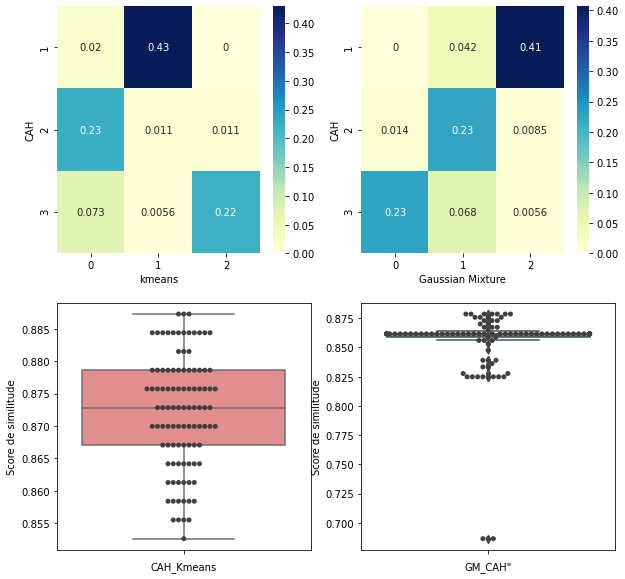

In [159]:
diction={"CAH_Kmeans":[],"GM_CAH":[]}

for i in range(100):
    CAH=donne_reel.CAH(60,regroupement=True,plot=False)
    kmeans=donne_reel.kmeans(3,regroupement=True,plot=False)
    kmeans+=1
    diction["CAH_Kmeans"].append(pd.crosstab(CAH,kmeans,normalize=True).apply(max,axis=1).sum())
for i in range(100):
    c=gauss(dataframe)
    CAHP=donne_reel.CAH(60,plot=False)
    CAHP.reset_index(inplace=True)
    result=pd.merge(CAHP,c, on ="echantillon")
    diction["GM_CAH"].append(pd.crosstab(result["index"],result["cluster"],normalize=True).apply(max,axis=1).sum())
score=pd.DataFrame(diction)
print(score.shape)
f, axes = plt.subplots(2, 2, figsize=(10, 10))
#

#

CAH=donne_reel.CAH(60,plot=False)
kmeans=donne_reel.kmeans(3,plot=False)
kmeans.index.name='kmeans'
kmeans.reset_index(inplace=True)
CAH.reset_index(inplace=True)
resulta=pd.merge(CAH,kmeans, on ="echantillon")

resulta.rename(columns={"index":"CAH",},inplace=True)
sns.heatmap(pd.crosstab(resulta["CAH"],resulta["kmeans"],normalize=True,),annot=True,cmap="YlGnBu",ax=axes[0, 0])

c=gauss(dataframe)
CAH=donne_reel.CAH(60,plot=False)
CAH.reset_index(inplace=True)
result=pd.merge(CAH,c, on ="echantillon")
result.rename(columns={"index":"CAH","cluster":"Gaussian Mixture"},inplace=True)
sns.heatmap(pd.crosstab(result["CAH"],result["Gaussian Mixture"],normalize=True, ),annot=True,cmap="YlGnBu",ax=axes[0, 1])

# Plot a simple histogram with binsize determined automatically
sns.boxplot(x="GM_CAH",data=score,orient="v" ,color="deepskyblue", ax=axes[1, 1])
ax = sns.swarmplot(x="GM_CAH",data=score,orient="v",ax=axes[1, 1], color=".25")
axes[1, 1].set_ylabel('Score de similitude')
axes[1, 1].set_xlabel('GM_CAH"')
# Plot a kernel density estimate and rug plot
sns.boxplot(x="CAH_Kmeans", data=score,orient="v", color="lightcoral", ax=axes[1, 0])
ax = sns.swarmplot(x="CAH_Kmeans",data=score,orient="v",ax=axes[1, 0], color=".25")
axes[1, 0].set_ylabel('Score de similitude')
axes[1, 0].set_xlabel('CAH_Kmeans')
plt.savefig('C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\resultat1\\comparaison_algorithme_classification.png')


Text(0.5, 1.0, 'comparaison de deux méthodes de classification')

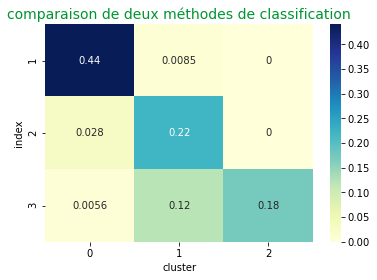

In [158]:

# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# define dataset
# define the model
def gauss(data):
    model = GaussianMixture(n_components=3)
    # fit the model
    model.fit(data)
    # assign a cluster to each example
    yhat = model.predict(data)
    # retrieve unique clusters
    clusters = unique(yhat)
    # create scatter plot for samples from each cluster
    nom=metadata[["echantillon"]]
    c=pd.DataFrame()
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        tab=nom.loc[row_ix]
        tab["cluster"]=cluster
        c=c.append(tab)
    return c
c=gauss(dataframe)
CAH=donne_reel.CAH(60,plot=False)
CAH.reset_index(inplace=True)
result=pd.merge(CAH,c, on ="echantillon")
result.rename(columns={"index":"CAH","cluster":"Gaussian Mixture"})
sns.heatmap(pd.crosstab(result["index"],result["cluster"],normalize=True,margins_name  = ["CAH" ,"Kmeans"] ),annot=True,cmap="YlGnBu")
plt.title("comparaison de deux méthodes de classification", fontsize=14, color='#009432')


[0 0 2 1 2 0 1 1 1 2 0 1 1 1 0 1 0 0 0 0 2 0 0 2 0 0 2 0 0 0 0 2 1 1 1 1 2
 1 2 2 1 2 0 0 2 2 2 2 0 0 0 2 2 2 1 1 0 0 2 0 0 0 2 2 0 1 2 2 2 1 1 1 2 2
 2 2 1 1 1 1 1 1 1 1 1 0 2 0 0 0 0 2 2 0 0 2 0 0 2 0 0 0 1 0 2 2 2 2 0 0 0
 0 2 0 2 2 2 0 2 0 1 1 1 2 0 1 0 0 0 1 0 0 1 1 1 1 1 2 1 2 0 2 2 2 2 2 2 1
 1 2 2 1 0 0 1 2 0 2 2 2 1 2 1 2 2 0 2 0 0 0 0 2 2 2 2 0 2 0 0 1 2 2 0 2 0
 1 2 1 0 0 0 0 1 0 2 0 0 0 1 2 2 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 2 2 0 0 0
 0 2 2 2 1 2 0 0 0 0 2 2 0 1 2 1 2 1 2 0 0 2 2 1 1 2 2 0 0 1 0 0 0 0 0 2 2
 1 2 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 2 2 0 0 0 2 2 0 1 1 0 0 0 0 0 0 0 1 0
 0 0 2 2 0 0 1 0 0 1 1 2 1 0 0 0 0 0 0 1 0 0 0 0 0 2 0 2 2 2 1 0 2 0 0 0 2
 0 2 2 2 0 0 1 1 0 2 0 0 2]


Text(0.5, 1.0, 'comparaison de deux méthodes de classification')

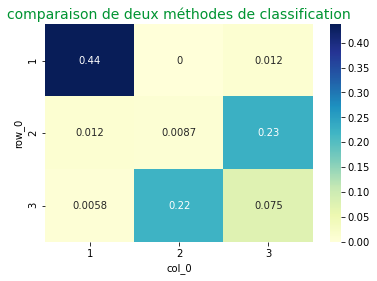

In [316]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
CAH=donne_reel.CAH(60,regroupement=True,plot=False)
kmeans=donne_reel.kmeans(3,regroupement=True,plot=False)
print(kmeans)
kmeans+=1

sns.heatmap(pd.crosstab(CAH,kmeans,normalize=True,margins_name  = ["CAH" ,"Kmeans"] ).so,annot=True,cmap="YlGnBu")
plt.title("comparaison de deux méthodes de classification", fontsize=14, color='#009432')


#plt.show()



In [91]:
from sklearn.cluster import DBSCAN
import sklearn.utils
import hdbscan

db=DBSCAN(eps= 7,min_samples=6).fit(dataframe)
labels=db.labels_

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=15, metric='euclidean', min_cluster_size=5, min_samples=2, p=None)
clusterer.fit(dataframe)
clusterer.labels_


array([ 0,  0, -1,  0, -1, -1,  0, -1,  0,  0,  0,  0, -1,  0, -1,  0,  0,
       -1, -1,  0, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1, -1,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  0, -1, -1,  0,  0,  0,  0,  0, -1,  0,
        0,  0, -1,  0, -1, -1,  0,  0, -1, -1,  0,  0,  0,  0, -1,  0,  0,
        0, -1,  0,  0,  0, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0, -1, -1,
       -1,  0, -1,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1,  0,  0,  0,
        0,  0, -1,  0, -1,  0,  0, -1,  0, -1, -1,  0,  0, -1,  0,  0,  0,
        0,  0, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,
        0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  1,  1,
        1,  0, -1,  0,  0,  0,  0, -1,  0,  0, -1, -1,  0,  0, -1,  0, -1,
       -1,  1,  0,  0,  0,  0, -1,  0,  0, -1, -1, -1,  0,  0, -1,  0,  0,
       -1, -1,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,
        0, -1, -1,  0, -1

[1 1 2 0 2 2 0 0 2 2 1 0 0 0 1 0 1 1 1 1 0 2 1 2 1 1 2 0 1 1 1 2 0 0 0 2 2
 2 2 2 0 2 1 1 2 2 2 2 1 1 1 2 2 0 0 0 1 1 0 1 1 1 2 2 2 0 0 2 2 0 0 0 2 2
 1 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 0 2 2 1 1 2 1 1 2 1 1 1 0 2 2 2 2 0 1 1 1
 1 2 1 2 0 2 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 2 0 2 1 2 2 2 2 2 0 0
 0 2 2 0 1 1 0 2 1 2 2 2 0 2 0 2 0 1 0 1 1 1 1 2 0 2 2 1 2 1 2 0 1 2 1 0 1
 0 2 0 1 1 1 1 0 1 1 1 1 1 0 2 2 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 2 2 1 1 2
 2 2 0 2 0 0 1 1 1 1 0 2 1 0 0 0 0 0 2 1 1 2 2 0 0 2 0 1 1 0 1 1 1 1 1 2 2
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 2 2 2 2 1 1 1 2 2 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 2 2 1 1 2 1 1 0 0 2 0 1 1 1 1 1 1 0 1 1 1 1 1 2 1 2 2
 0 0 2 2 2 1 1 2 1 2 2 2 1 1 0 0 1 2 2 1 2]
(array([], dtype=int64),)


In [211]:
dataframe.to_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\datafram_acp.csv")
data.to_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\data_acp.csv")

In [389]:
data2.isna().sum()
data=data2[["micianteriorite_chir_1","micianteriorite_chir_2"]]
data.dropna(inplace=True)


C:\Users\franc\Documents\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [390]:
data.reset_index(inplace=True)
data2.reset_index(inplace=True)
data=pd.merge(data,data2, on="echantillon")
data.set_index("echantillon",inplace=True)
data2.set_index("echantillon",inplace=True)

In [397]:
data=data[["nombre_op_chir", "traitement_imu", "traitement_mtx",
                      "traitement_humira", "traitement_ustekinumab", "traitement_vedolizumab","remicade","micievolution_montreal_b_date","groupe_cah"]]

(346, 70)

In [398]:
data=data.fillna("aucune_info")
data

data.to_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\data2.csv")

###########################################################
0.005606071244127112


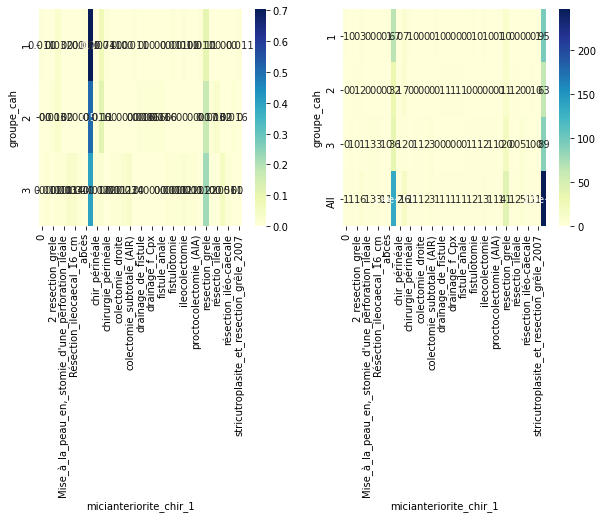

###########################################################
0.0053312954799068675


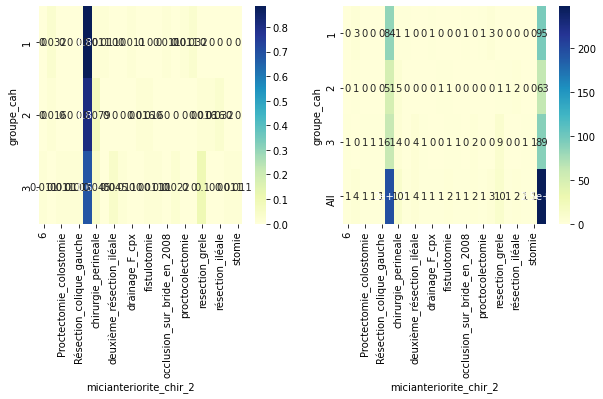

###########################################################
0.19084083261133203


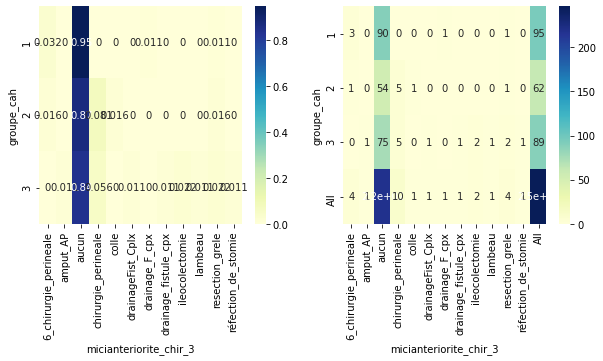

###########################################################
0.3096816573290184


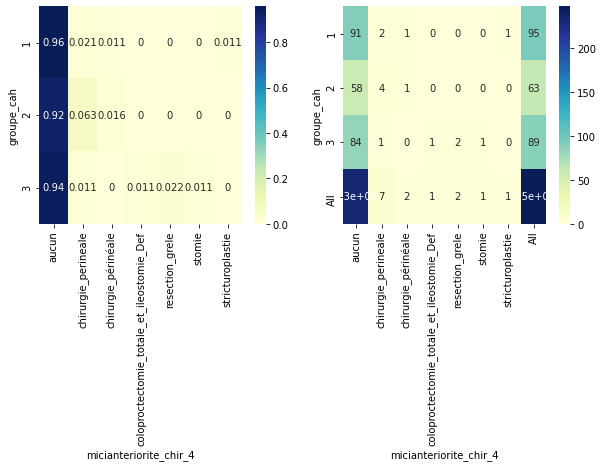

###########################################################
0.18149757684750767


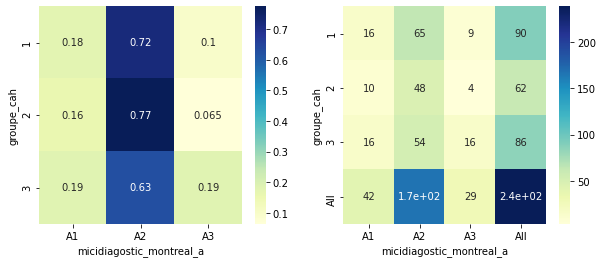

###########################################################
0.033775606137969164


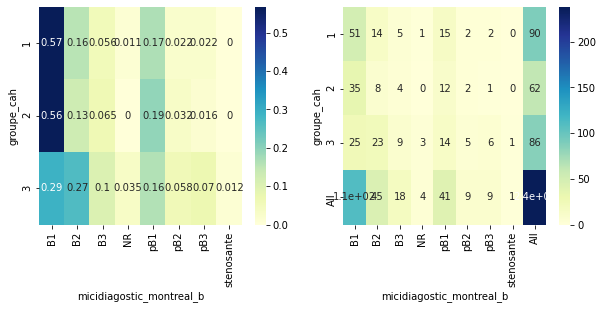

###########################################################
0.4638139468120416


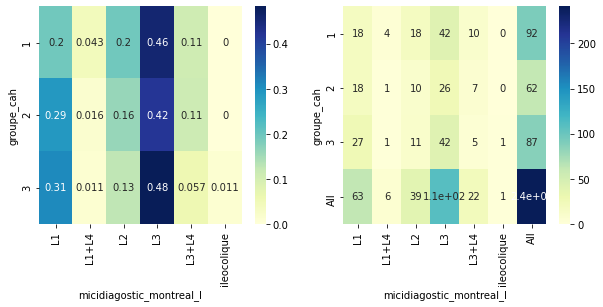

###########################################################
0.059042571529048286


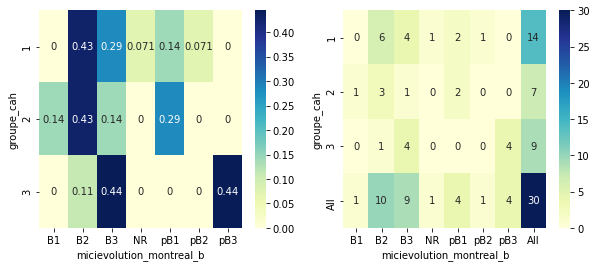

###########################################################
0.7415163981097748


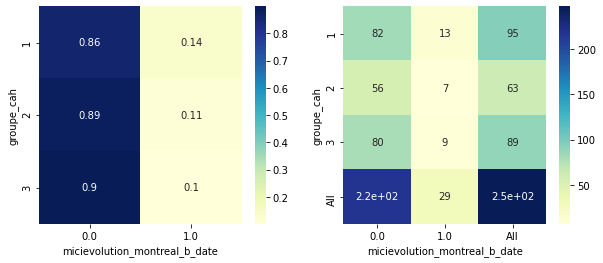

###########################################################
0.023508873444133827


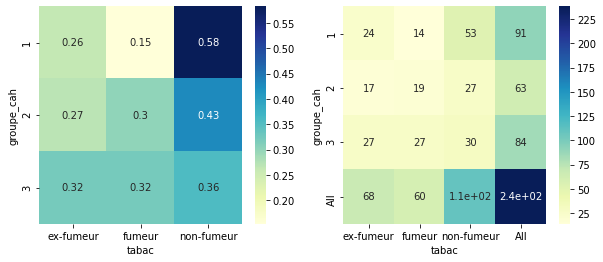

###########################################################
0.48617438916176264


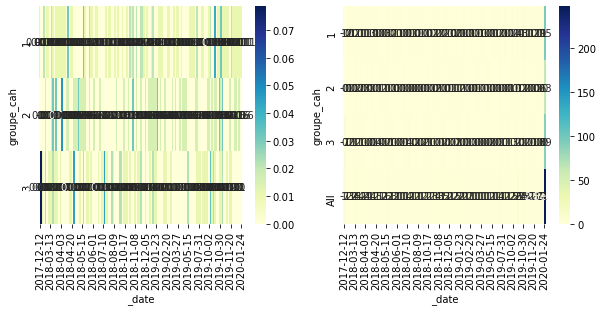

###########################################################
0.34317381046219114


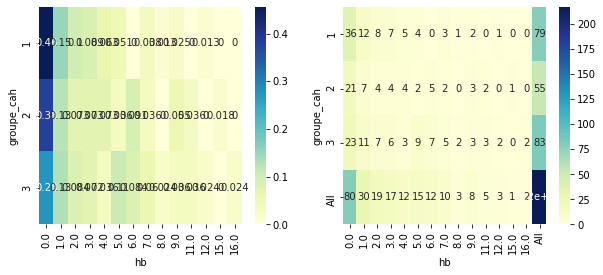

###########################################################
0.6935750730298303


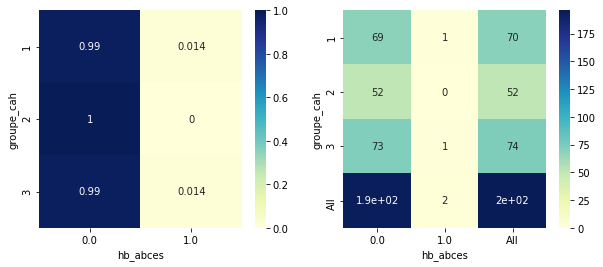

###########################################################
0.2604392764300792


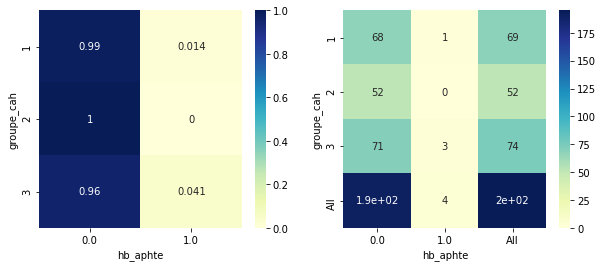

###########################################################
0.7173847056379035


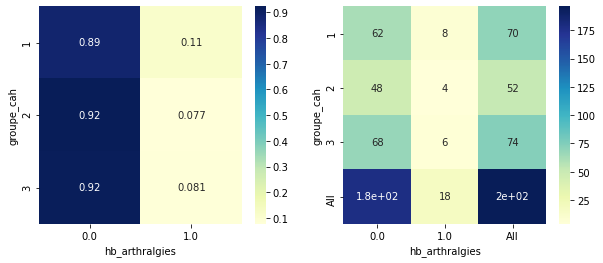

###########################################################
0.17720046803820036


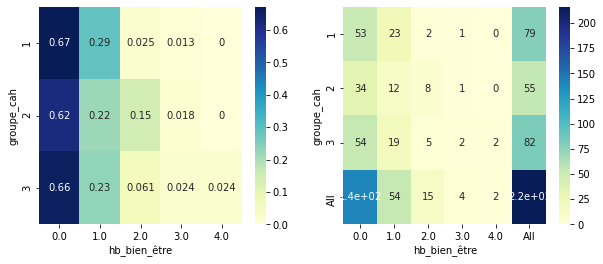

###########################################################
0.08948336520886681


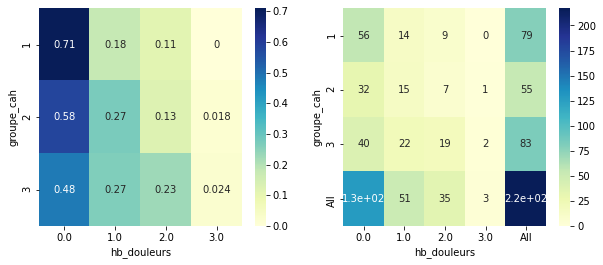

###########################################################
0.01515457026291672


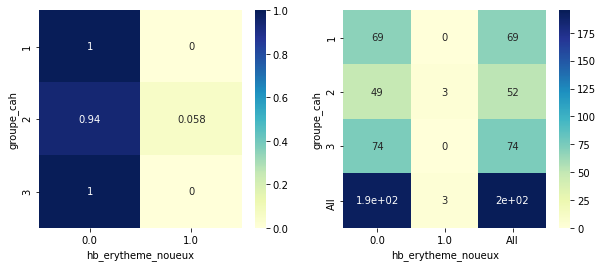

###########################################################
0.36350749757113593


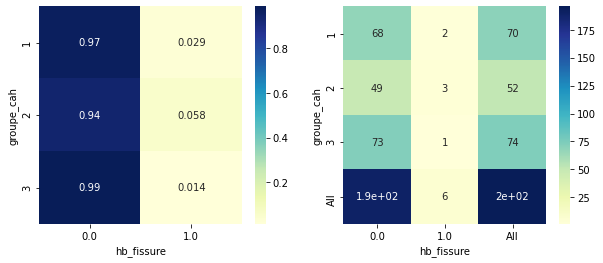

###########################################################
0.3559826950977906


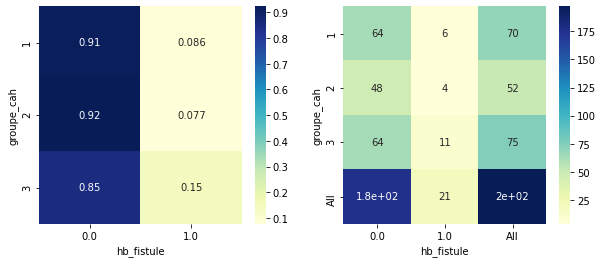

###########################################################
0.25704290012950604


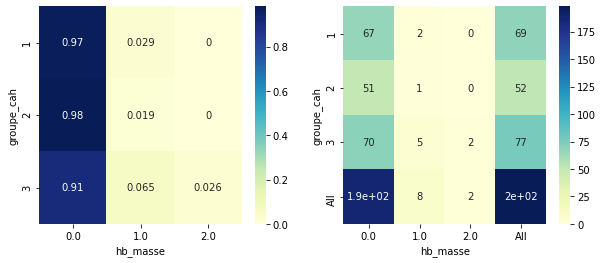

###########################################################
1.0


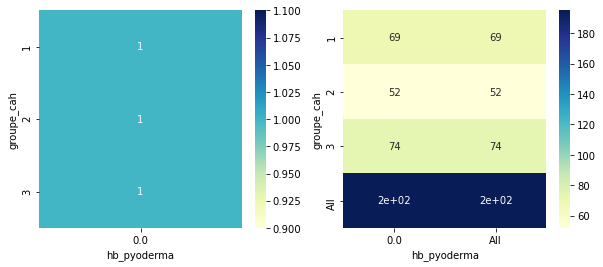

###########################################################
0.11624330656115953


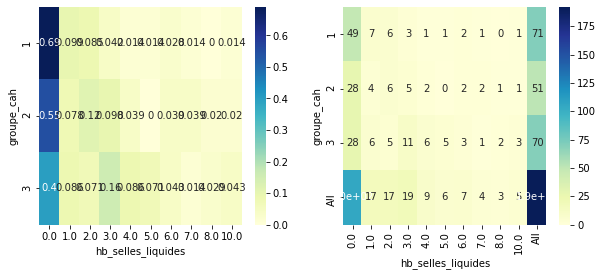

###########################################################
1.0


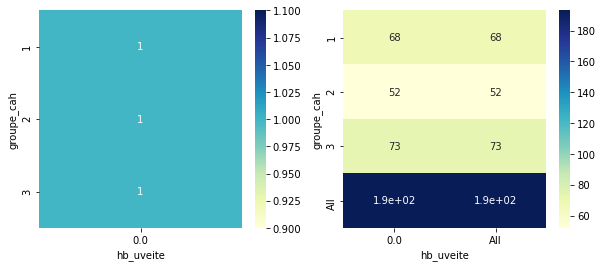

###########################################################
0.08879474417693155


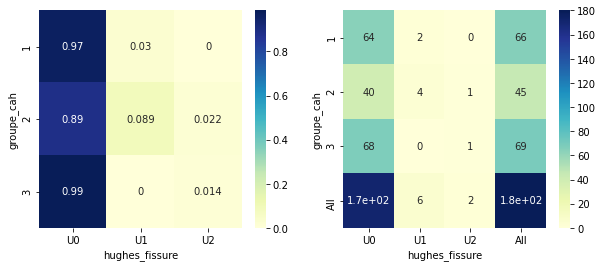

###########################################################
0.3604374810264074


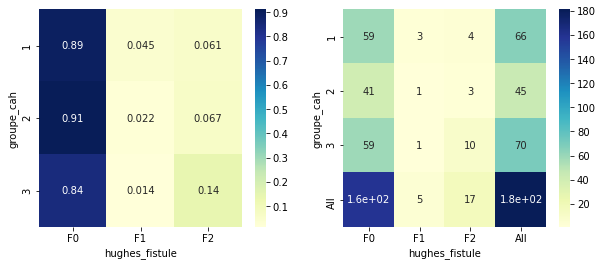

###########################################################
0.31373332359242556


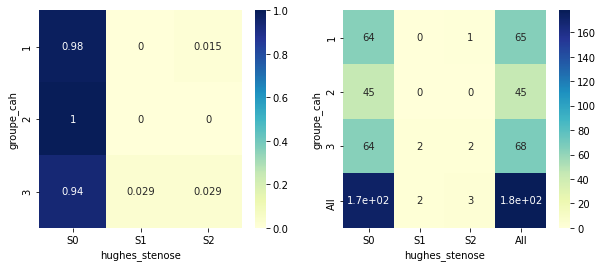

###########################################################
1.0


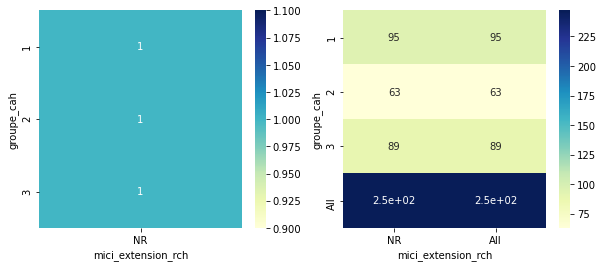

###########################################################
1.0


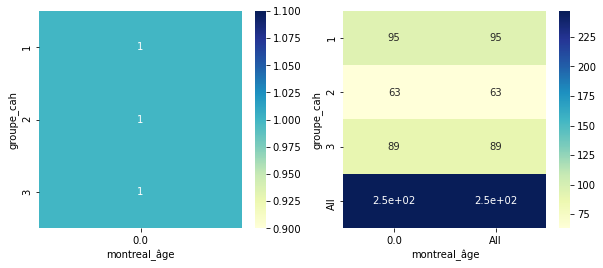

###########################################################
0.5331739982373715


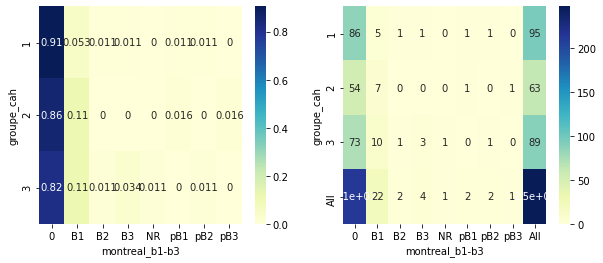

###########################################################
0.14024312347052714


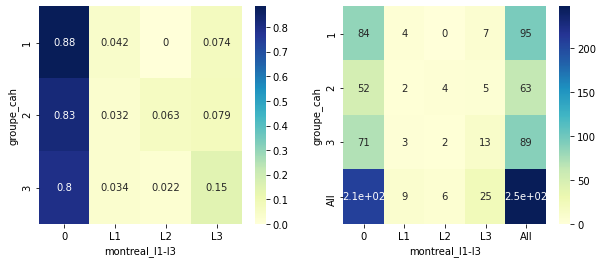

###########################################################
0.6815761817418999


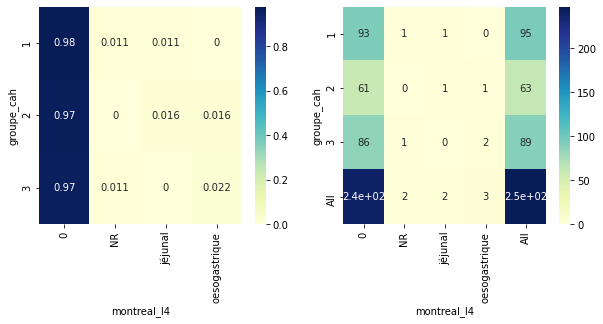

###########################################################
0.14419922056150733


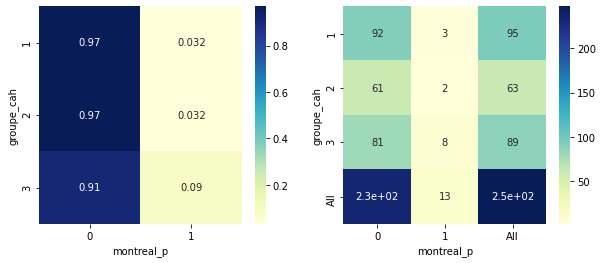

###########################################################
0.7276233896079563


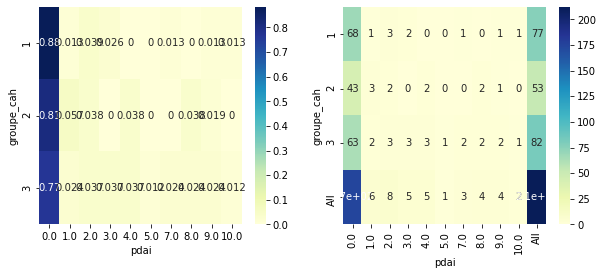

###########################################################
0.49592829551878526


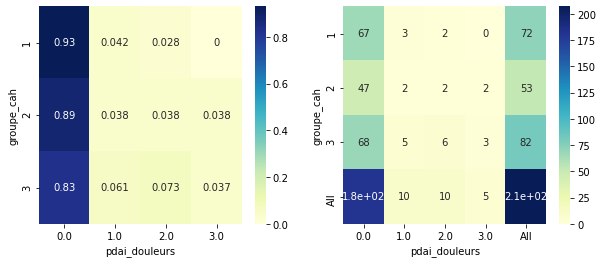

###########################################################
0.5002075130575565


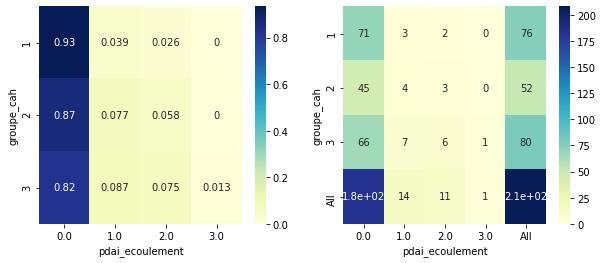

###########################################################
0.6266145161712486


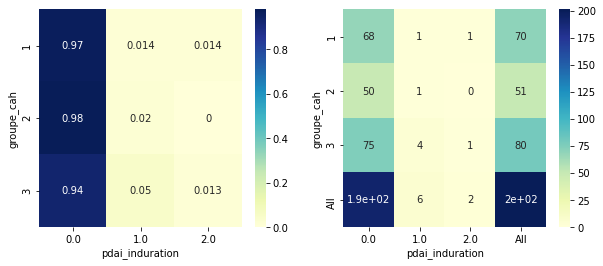

###########################################################
0.14734761096659024


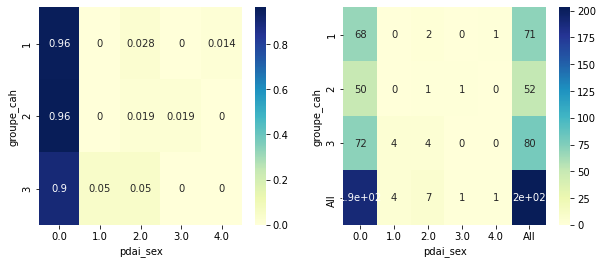

###########################################################
0.16447614063432248


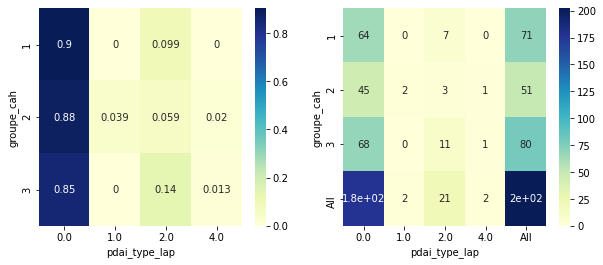

###########################################################
0.1643832285716081


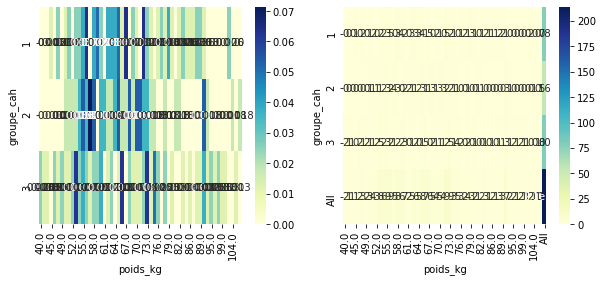

###########################################################
0.5487450177849846


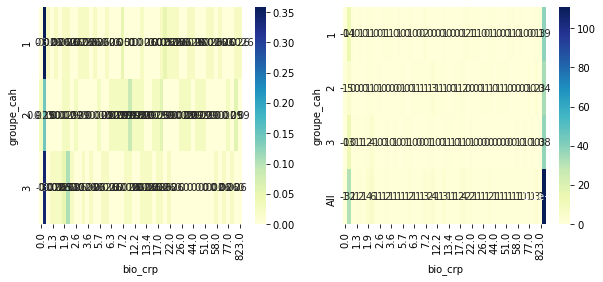

###########################################################
0.2650259152973616


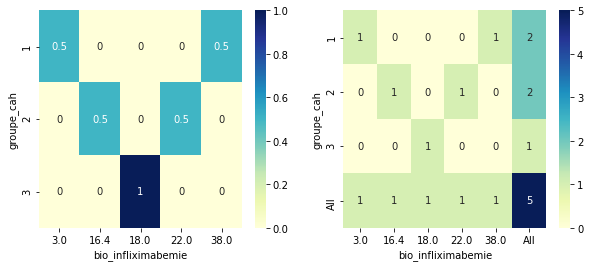

###########################################################
0.00174879800993686


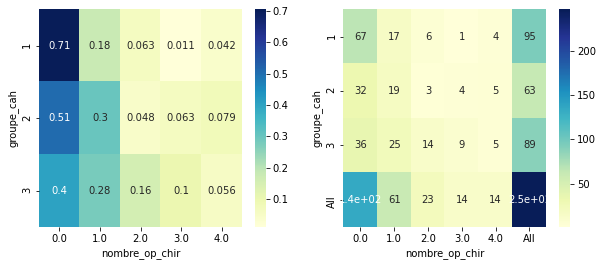

###########################################################
0.0327063255919726


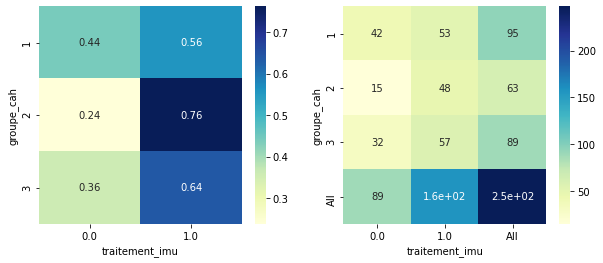

###########################################################
0.1362073729067236


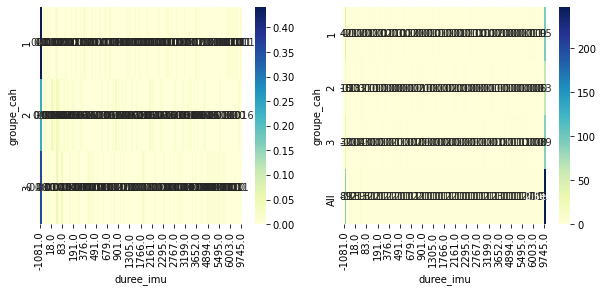

###########################################################
0.22198497886302285


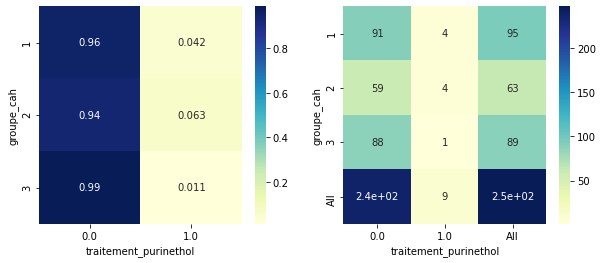

###########################################################
0.22168767276883955


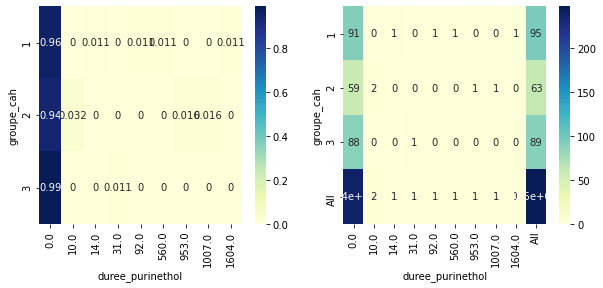

###########################################################
0.011921467595083862


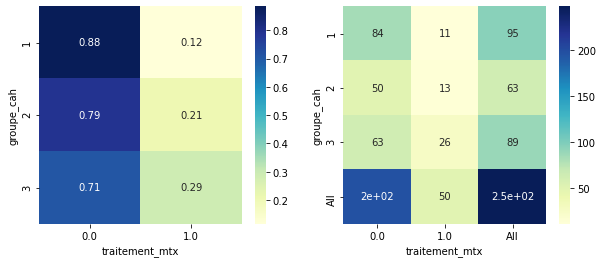

###########################################################
0.1925746021425963


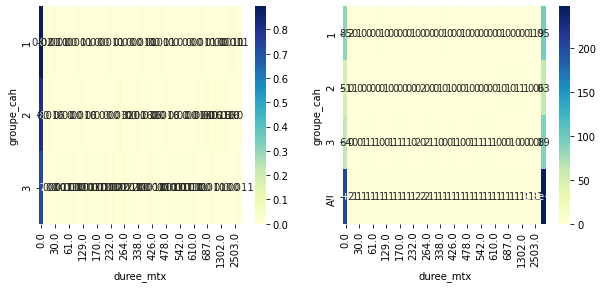

###########################################################
0.4224250566718074


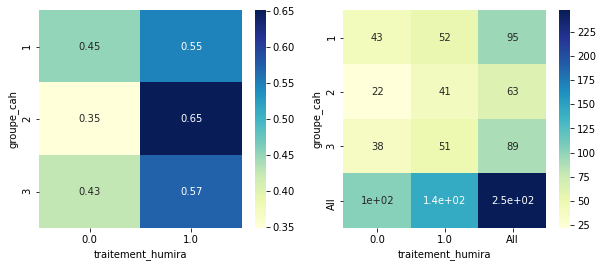

###########################################################
0.10838090969561649


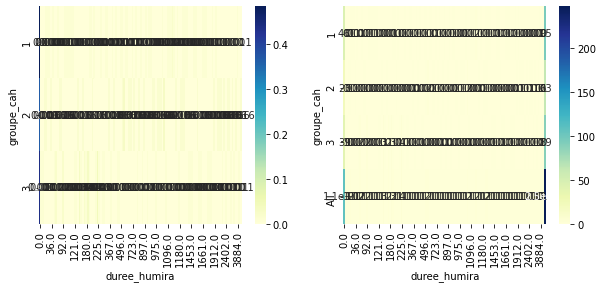

###########################################################
0.025637437765739117


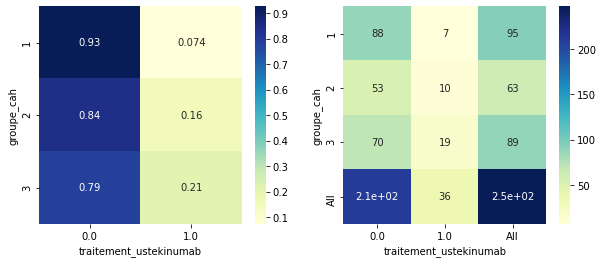

###########################################################
0.253615495453415


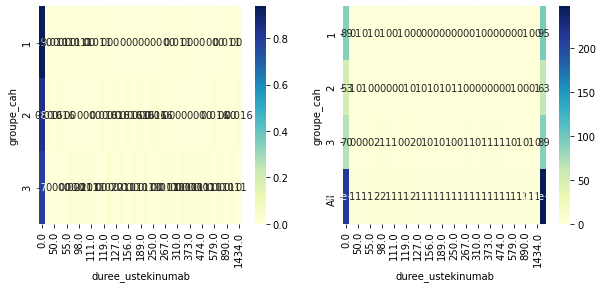

###########################################################
0.08082996093624595


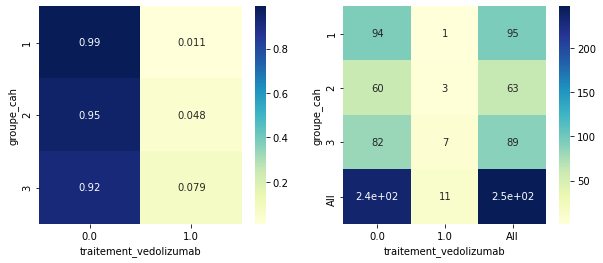

###########################################################
0.40100061403526965


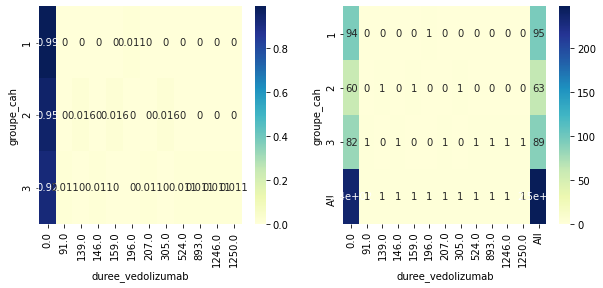

###########################################################
1.0


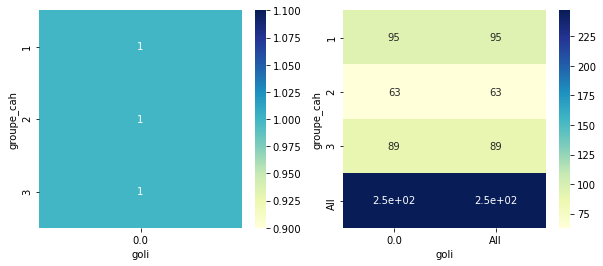

###########################################################
0.5944490114502347


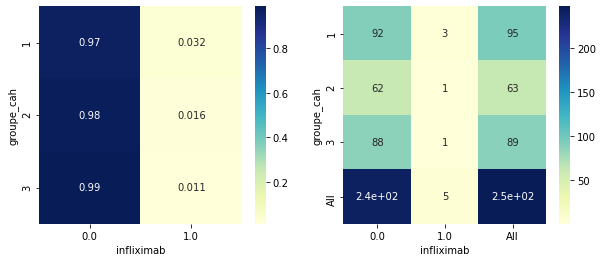

###########################################################
7.290912724426315e-06


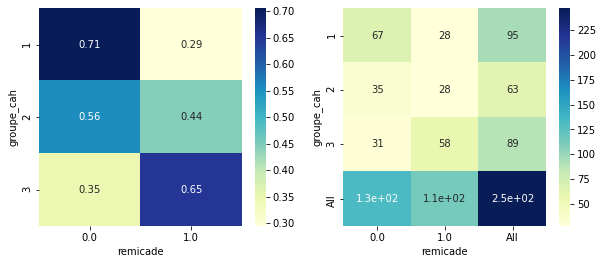

###########################################################
0.4978921111223217


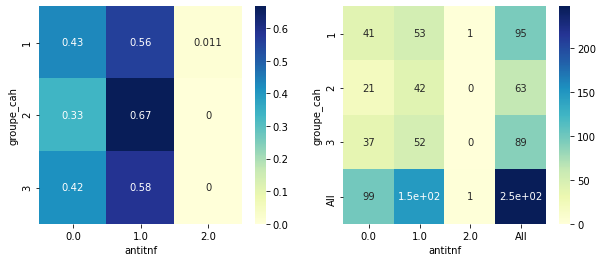

###########################################################
0.19005184862567884


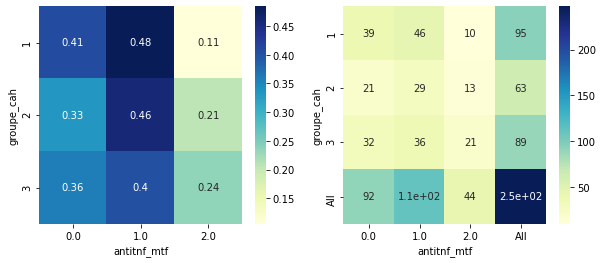

###########################################################
2.918016497096262e-05


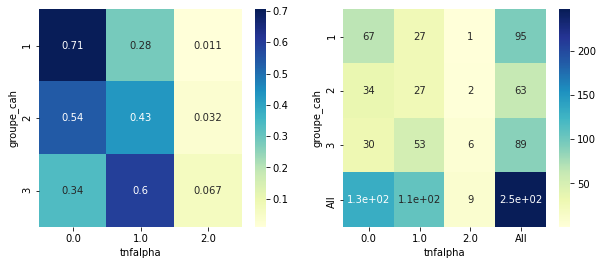

###########################################################
0.04637655184618834


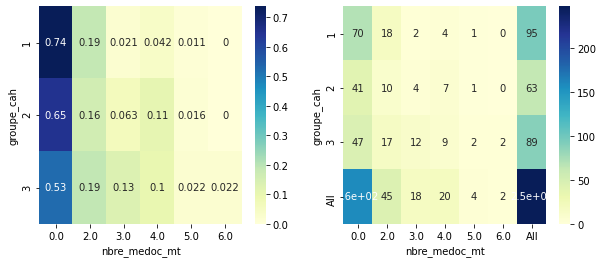

###########################################################
0.2767575852665914


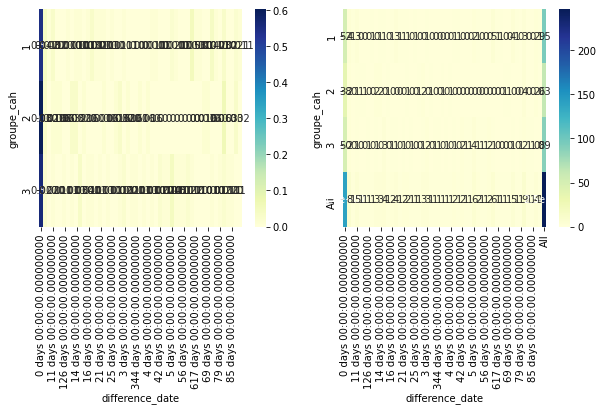

###########################################################
0.3622801878120351


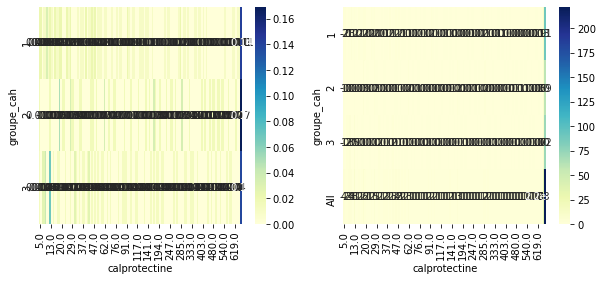

###########################################################
0.00022147701178155225


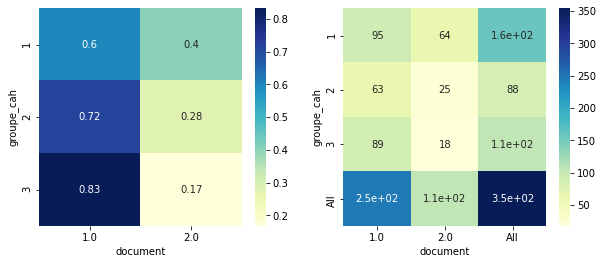

###########################################################
0.001916496775514113


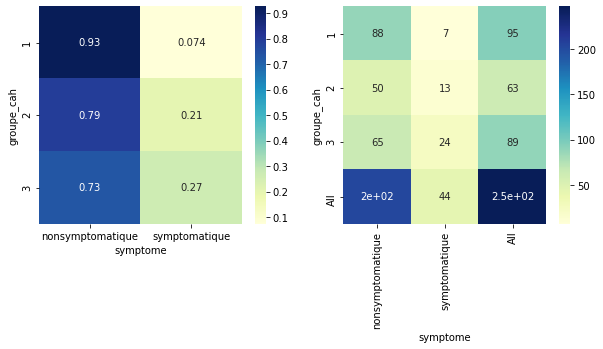

###########################################################
0.050411730036628744


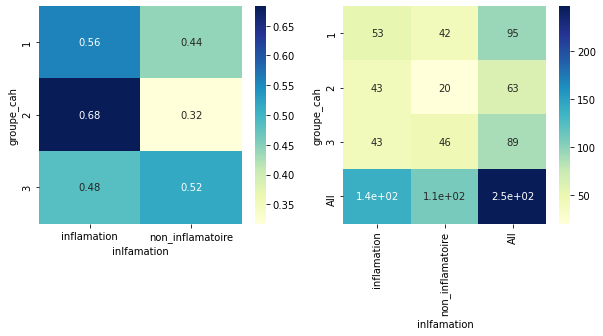

###########################################################
0.002885044485228799


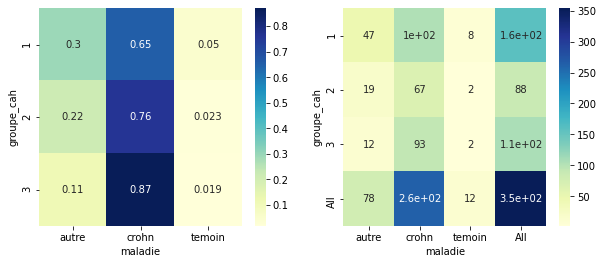

###########################################################
0.001230039574876781


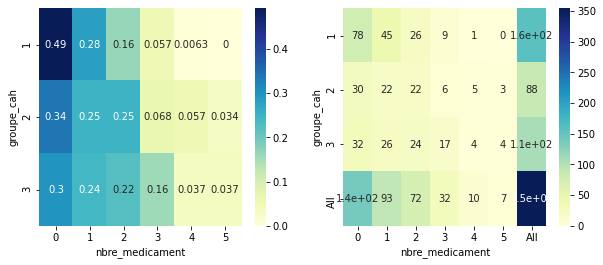

###########################################################
6.4562711163920915e-152


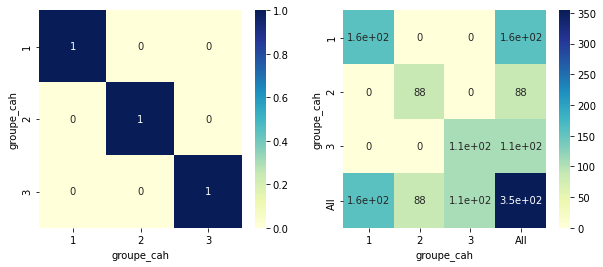

In [24]:
data=pd.DataFrame()

for i in donne_reel_groupe.index.unique():
    groupe=donne_reel_groupe.loc[i]["echantillon"]
    groupe=pd.merge(groupe,metadata,on="echantillon")
    groupe["groupe_cah"]=i

    data=data.append(groupe)

data.set_index("echantillon", inplace=True)
data2=data[['micianteriorite_chir_1', 'micianteriorite_chir_2',
       'micianteriorite_chir_3', 'micianteriorite_chir_4',
       'micidiagostic_montreal_a', 'micidiagostic_montreal_b',
       'micidiagostic_montreal_l', 'micievolution_montreal_b',
        'tabac', 'hb', 'hb_abces',
       'hb_aphte', 'hb_arthralgies', 'hb_bien_être', 'hb_douleurs',
       'hb_erytheme_noueux', 'hb_fissure', 'hb_fistule', 'hb_masse',
       'hb_pyoderma', 'hb_selles_liquides', 'hughes_fissure',
       'hughes_fistule', 'hughes_stenose',
        'montreal_b1-b3', 'montreal_l1-l3', 'montreal_l4',
       'montreal_p', 'pdai', 'pdai_douleurs', 'pdai_ecoulement',
       'pdai_induration', 'pdai_sex', 'pdai_type_lap', 'bio_crp',
        'bio_infliximabemie', 'nombre_op_chir',
       'traitement_imu', 'traitement_purinethol', 'traitement_mtx', 'traitement_humira', 'traitement_ustekinumab',
       'traitement_vedolizumab', 'goli', 'infliximab',
       'remicade','maladie','micievolution_montreal_b_date',
        'groupe_cah']]
data2

for i in data.columns:
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(pd.crosstab(data["groupe_cah"],data[i]))
    print("###########################################################")
    print(st_p)
    sns.heatmap(pd.crosstab(data["groupe_cah"],data[i],margins=True),annot=True,cmap="YlGnBu",ax=axes[1])
    sns.heatmap(pd.crosstab(data["groupe_cah"],data[i],normalize="index"),annot=True,cmap="YlGnBu",ax=axes[0])
    #plt.savefig("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\resultat_complementaire\\"+i)
    plt.show()
    
liste=["micievolution_montreal_b_date","_date","hb_selles_liquides","poids_kg"]

In [182]:
docu=pd.merge(dataframe,data,on="echantillon")
docu

Cluster_161  Cluster_24  Cluster_26  Cluster_20  Cluster_23  \
echantillon                                                                 
100_S48_L001     0.454524   -0.548762    0.493671   -0.653692    0.129585   
101_S49_L001     0.104425   -0.637575   -0.134426   -0.085893    0.784804   
102_S50_L001     1.150389    1.935551   -0.441713    0.649959    0.222599   
103_S51_L001     1.353756   -0.939680   -1.449873    1.078588    1.545061   
104_S52_L001     1.448213   -0.845332   -1.338720    0.275020    0.418432   
...                   ...         ...         ...         ...         ...   
96_S44_L001      1.126508   -0.922576   -0.477440   -0.425377    1.613381   
97_S45_L001     -0.981609   -0.487447    0.442248   -1.582187   -1.251656   
98_S46_L001      1.089560   -0.861256    0.162547    0.913025   -0.479383   
99_S47_L001      0.712815   -0.874564   -0.643230    0.132905    1.420455   
9_S9_L001       -1.021185    0.160710    0.762451   -1.368593   -0.483596   

              Cluster_191  Cluster_560  Cluster_462  Cluster_463  Cluster_305  \
echantillon                                                                     
100_S48_L001    -0.221560    -0.070950     0.439661     0.002983     0.349645   
101_S49_L001    -0.340001    -0.955224    -0.637858     0.413242    -0.415353   
102_S50_L001    -0.726262    -1.013762    -0.703999    -1.005061    -0.501648   
103_S51_L001    -0.742890    -1.095664    -0.796540    -1.103024     0.569666   
104_S52_L001    -0.617068    -1.037765    -0.731120     1.357565    -0.537032   
...                   ...          ...          ...          ...          ...   
96_S44_L001     -0.720080    -0.782038    -0.442175    -0.727892    -0.418447   
97_S45_L001     -0.139790    -0.244147     0.165586    -0.084513     0.632898   
98_S46_L001     -0.638304    -0.910017    -0.586778     0.904193    -0.348710   
99_S47_L001     -0.656051    -1.090513     1.345124     0.965813    -0.614793   
9_S9_L001        3.181566    -0.006425     0.434188     0.199830     0.404824   

              Cluster_303  Cluster_302  Cluster_263  Cluster_264  Cluster_267  \
echantillon                                                                     
100_S48_L001    -0.476267     2.729661    -0.544501     0.065756    -0.508703   
101_S49_L001    -0.703599    -0.384193    -0.687955    -0.570390    -1.098631   
102_S50_L001    -1.018263    -0.458793    -1.034209    -0.641887     0.973249   
103_S51_L001    -0.028381    -0.563169     1.680140    -0.741921     1.566350   
104_S52_L001     0.148196    -0.489382    -0.928259    -0.671204     0.489829   
...                   ...          ...          ...          ...          ...   
96_S44_L001     -1.011624     3.592135     0.414011    -0.570626    -0.906206   
97_S45_L001     -0.388454     0.158100    -0.465160     0.298110    -0.308560   
98_S46_L001     -0.923806    -0.326581     1.703205    -0.515174     0.379590   
99_S47_L001     -0.842607    -0.556605     1.185022    -0.735630     1.526317   
9_S9_L001       -0.437807     0.096887    -0.509752     0.111473    -0.467114   

              Cluster_417  Cluster_418  Cluster_139  Cluster_131  Cluster_136  \
echantillon                                                                     
100_S48_L001    -0.126381    -0.174449    -0.501201     0.061091     0.448738   
101_S49_L001     0.706603    -1.098124    -0.451363     0.958760     2.208855   
102_S50_L001    -1.096538     1.185462    -1.060341     0.778554     1.023851   
103_S51_L001    -1.182168     1.349797    -1.078763     0.814042    -1.315404   
104_S52_L001     1.389050     1.018242    -0.538176     0.801268    -1.215403   
...                   ...          ...          ...          ...          ...   
96_S44_L001      0.834944    -0.902433    -1.053492     0.516182     0.131718   
97_S45_L001     -0.291889    -0.294644     0.767316     1.133224     0.733793   
98_S46_L001      0.468403     1.367744    -0.962896     0.795804     0.694761   
99_S47_L001  

In [178]:
docu.to_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\resultat1\\acp.csv")

In [168]:
del(metadata["Chao1"])
del(metadata["Shannon"])
del(metadata["se.chao1"])

In [189]:
#data.drop(["_date" ,"difference_date" ,"document"],axis='columns', inplace=True)

a=data.loc[:, ~data.columns.isin(["poids_kg",
"bio_crp"
"duree_imu",
"duree_purinethol",
"duree_mtx",
"duree_humira",
"duree_ustekinumab",
"duree_vedolizumab"])]
a=data[["bio_infliximabemie","nombre_op_chir","traitement_imu","traitement_purinethol","traitement_mtx", "traitement_humira","traitement_ustekinumab","traitement_vedolizumab","goli","infliximab","remicade","antitnf","antitnf_mtf","tnfalpha","nbre_medoc_mt","calprotectine","symptome","inlfamation","maladie","nbre_medicament","groupe_cah"]]


In [154]:
data["groupe_cah"].value_counts()

3    161
1    126
2     83
Name: groupe_cah, dtype: int64

In [72]:
def plot_classification_report(cr, title='Classification report ',  cmap=plt.cm.Blues,axe=None):

    lines = cr.split('\n')


    diction={}
    for line in lines[1 : ]:
        t = line.split()
        if t :
            if t[0]=="accuracy":
                diction[t[0]]=[0,0]+t[1:]
            elif t[0] == "macro" or t[0]=="weighted":
                diction[" ".join(t[0:2])]=t[2:]

            else:
                diction[t[0]]=t[1:]
    index = lines[0].split()
    diction
    clpp=pd.DataFrame(diction, index=index)
    clpp=clpp.T
    clpp=clpp. astype (float)
    del(clpp["support"])
    sns.heatmap(clpp,annot=True,cmap=cmap,ax=axe)
    plt.gcf().suptitle(title)

In [183]:
docu

Cluster_161  Cluster_24  Cluster_26  Cluster_20  Cluster_23  \
echantillon                                                                 
100_S48_L001     0.454524   -0.548762    0.493671   -0.653692    0.129585   
101_S49_L001     0.104425   -0.637575   -0.134426   -0.085893    0.784804   
102_S50_L001     1.150389    1.935551   -0.441713    0.649959    0.222599   
103_S51_L001     1.353756   -0.939680   -1.449873    1.078588    1.545061   
104_S52_L001     1.448213   -0.845332   -1.338720    0.275020    0.418432   
...                   ...         ...         ...         ...         ...   
96_S44_L001      1.126508   -0.922576   -0.477440   -0.425377    1.613381   
97_S45_L001     -0.981609   -0.487447    0.442248   -1.582187   -1.251656   
98_S46_L001      1.089560   -0.861256    0.162547    0.913025   -0.479383   
99_S47_L001      0.712815   -0.874564   -0.643230    0.132905    1.420455   
9_S9_L001       -1.021185    0.160710    0.762451   -1.368593   -0.483596   

              Cluster_191  Cluster_560  Cluster_462  Cluster_463  Cluster_305  \
echantillon                                                                     
100_S48_L001    -0.221560    -0.070950     0.439661     0.002983     0.349645   
101_S49_L001    -0.340001    -0.955224    -0.637858     0.413242    -0.415353   
102_S50_L001    -0.726262    -1.013762    -0.703999    -1.005061    -0.501648   
103_S51_L001    -0.742890    -1.095664    -0.796540    -1.103024     0.569666   
104_S52_L001    -0.617068    -1.037765    -0.731120     1.357565    -0.537032   
...                   ...          ...          ...          ...          ...   
96_S44_L001     -0.720080    -0.782038    -0.442175    -0.727892    -0.418447   
97_S45_L001     -0.139790    -0.244147     0.165586    -0.084513     0.632898   
98_S46_L001     -0.638304    -0.910017    -0.586778     0.904193    -0.348710   
99_S47_L001     -0.656051    -1.090513     1.345124     0.965813    -0.614793   
9_S9_L001        3.181566    -0.006425     0.434188     0.199830     0.404824   

              Cluster_303  Cluster_302  Cluster_263  Cluster_264  Cluster_267  \
echantillon                                                                     
100_S48_L001    -0.476267     2.729661    -0.544501     0.065756    -0.508703   
101_S49_L001    -0.703599    -0.384193    -0.687955    -0.570390    -1.098631   
102_S50_L001    -1.018263    -0.458793    -1.034209    -0.641887     0.973249   
103_S51_L001    -0.028381    -0.563169     1.680140    -0.741921     1.566350   
104_S52_L001     0.148196    -0.489382    -0.928259    -0.671204     0.489829   
...                   ...          ...          ...          ...          ...   
96_S44_L001     -1.011624     3.592135     0.414011    -0.570626    -0.906206   
97_S45_L001     -0.388454     0.158100    -0.465160     0.298110    -0.308560   
98_S46_L001     -0.923806    -0.326581     1.703205    -0.515174     0.379590   
99_S47_L001     -0.842607    -0.556605     1.185022    -0.735630     1.526317   
9_S9_L001       -0.437807     0.096887    -0.509752     0.111473    -0.467114   

              Cluster_417  Cluster_418  Cluster_139  Cluster_131  Cluster_136  \
echantillon                                                                     
100_S48_L001    -0.126381    -0.174449    -0.501201     0.061091     0.448738   
101_S49_L001     0.706603    -1.098124    -0.451363     0.958760     2.208855   
102_S50_L001    -1.096538     1.185462    -1.060341     0.778554     1.023851   
103_S51_L001    -1.182168     1.349797    -1.078763     0.814042    -1.315404   
104_S52_L001     1.389050     1.018242    -0.538176     0.801268    -1.215403   
...                   ...          ...          ...          ...          ...   
96_S44_L001      0.834944    -0.902433    -1.053492     0.516182     0.131718   
97_S45_L001     -0.291889    -0.294644     0.767316     1.133224     0.733793   
98_S46_L001      0.468403     1.367744    -0.962896     0.795804     0.694761   
99_S47_L001  

In [247]:
phylum=pd.read_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\document_inportant\\phylum.csv")
phylum.rename(columns={"Unnamed: 0": "cluster"},inplace=True
             )
del(phylum["Species"])
a=bst.get_fscore ()
liste1=[]
liste2=[]
for key,i in a.items():
    liste1.append(key)
    liste2.append(i)
df=pd.DataFrame({"cluster":liste1,"score":liste2})
score=pd.merge(df,phylum, on ="cluster")
score.sort_values(by = 'score',ascending = False,inplace=True)
score["cluster"]

15      Cluster_3
11    Cluster_213
0      Cluster_44
19     Cluster_36
46    Cluster_173
29      Cluster_8
12    Cluster_161
28     Cluster_90
5     Cluster_364
47    Cluster_405
16     Cluster_58
2     Cluster_128
21    Cluster_205
40     Cluster_14
10    Cluster_216
13     Cluster_26
42    Cluster_560
62    Cluster_170
27    Cluster_197
43      Cluster_5
39     Cluster_18
64    Cluster_211
37     Cluster_79
54    Cluster_158
36     Cluster_96
33    Cluster_231
30     Cluster_61
35    Cluster_463
17    Cluster_196
25    Cluster_141
7     Cluster_109
4     Cluster_206
9      Cluster_13
18     Cluster_55
14    Cluster_174
60     Cluster_57
55     Cluster_33
56     Cluster_73
57     Cluster_59
58    Cluster_236
59    Cluster_221
26    Cluster_288
53    Cluster_149
61     Cluster_69
63    Cluster_136
3     Cluster_181
65     Cluster_10
66    Cluster_209
67    Cluster_455
68    Cluster_318
69    Cluster_305
6     Cluster_418
49    Cluster_187
52     Cluster_89
51     Cluster_17
24      Cl

In [249]:
score.head(70)

cluster  score    Domain             Phylum                Class  \
15    Cluster_3      6  Bacteria       Bacteroidota          Bacteroidia   
11  Cluster_213      6  Bacteria         Firmicutes           Clostridia   
0    Cluster_44      5  Bacteria         Firmicutes           Clostridia   
19   Cluster_36      5  Bacteria         Firmicutes           Clostridia   
46  Cluster_173      4  Bacteria         Firmicutes           Clostridia   
29    Cluster_8      4  Bacteria         Firmicutes           Clostridia   
12  Cluster_161      4  Bacteria         Firmicutes           Clostridia   
28   Cluster_90      4  Bacteria         Firmicutes           Clostridia   
5   Cluster_364      4  Bacteria         Firmicutes           Clostridia   
47  Cluster_405      3  Bacteria         Firmicutes           Clostridia   
16   Cluster_58      3  Bacteria         Firmicutes           Clostridia   
2   Cluster_128      3  Bacteria     Fusobacteriota        Fusobacteriia   
21  Cluster_205      3  Bacteria         Firmicutes           Clostridia   
40   Cluster_14      3  Bacteria         Firmicutes           Clostridia   
10  Cluster_216      3  Bacteria         Firmicutes           Clostridia   
13   Cluster_26      3  Bacteria         Firmicutes              Bacilli   
42  Cluster_560      2  Bacteria   Actinobacteriota       Coriobacteriia   
62  Cluster_170      2  Bacteria         Firmicutes           Clostridia   
27  Cluster_197      2  Bacteria         Firmicutes           Clostridia   
43    Cluster_5      2  Bacteria         Firmicutes           Clostridia   
39   Cluster_18      2  Bacteria         Firmicutes              Bacilli   
64  Cluster_211      2  Bacteria       Bacteroidota          Bacteroidia   
37   Cluster_79      2  Bacteria         Firmicutes        Negativicutes   
54  Cluster_158      2  Bacteria         Firmicutes        Negativicutes   
36   Cluster_96      2  Bacteria       Bacteroidota          Bacteroidia   
33  Cluster_231      2  Bacteria         Firmicutes           Clostridia   
30   Cluster_61      2  Bacteria         Firmicutes              Bacilli   
35  Cluster_463      2  Bacteria         Firmicutes              Bacilli   
17  Cluster_196      2  Bacteria         Firmicutes           Clostridia   
25  Cluster_141      2  Bacteria         Firmicutes           Clostridia   
7   Cluster_109      2  Bacteria         Firmicutes           Clostridia   
4   Cluster_206      2  Bacteria         Firmicutes           Clostridia   
9    Cluster_13      2  Bacteria         Firmicutes        Negativicutes   
18   Cluster_55      2  Bacteria         Firmicutes           Clostridia   
14  Cluster_174      2  Bacteria         Firmicutes              Bacilli   
60   Cluster_57      1  Bacteria     Proteobacteria  Gammaproteobacteria   
55   Cluster_33      1  Bacteria         Firmicutes              Bacilli   
56   Cluster_73      1  Bacteria         Firmicutes              Bacilli   
57   Cluster_59      1  Bacteria     Proteobacteria  Gammaproteobacteria   
58  Cluster_236      1  Bacteria       Bacteroidota          Bacteroidia   
59  Cluster_221      1  Bacteria         Firmicutes           Clostridia   
26  Cluster_288      1  Bacteria     Proteobacteria  Gammaproteobacteria   
53  Cluster_149      1  Bacteria   Desulfobacterota     Desulfovibrionia   
61   Cluster_69      1  Bacteria         Firmicutes           Clostridia   
63  Cluster_136      1  Bacteria     Proteobacteria  Gammaproteobacteria   
3   Cluster_181      1  Bacteria         Firmicutes        Negativicutes   
65   Cluster_10      1  Bacteria         Firmicutes           Clostridia   
66  Cluster_209      1  Bacteria         Firmicutes           Clostridia   
67  Cluster_455      1  Bacteria   Actinobacteriota       Coriobacteriia   
68  Cluster_318      1  Bacteria         Firmicutes           Clostridia   
69  Cluster_305      1  Bacteria         Firmicutes              Bacilli   
6   Cluster_418      1  Bacteria         Firmicutes     

              precision    recall  f1-score   support

           1       1.00      0.97      0.98        32
           2       0.85      0.94      0.89        18
           3       0.95      0.90      0.93        21

    accuracy                           0.94        71
   macro avg       0.93      0.94      0.94        71
weighted avg       0.95      0.94      0.94        71

Predicted   1.0  2.0  3.0
True_label               
1            31    1    0
2             0   17    1
3             0    2   19


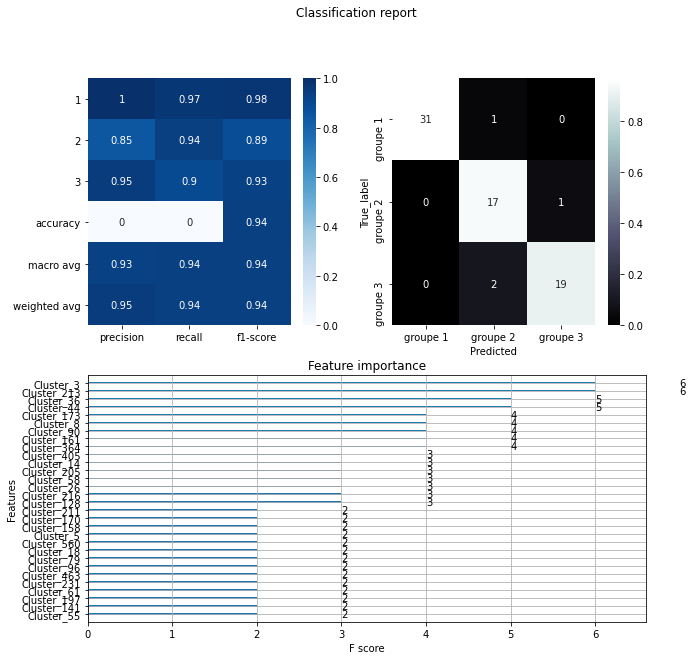

<Figure size 504x432 with 0 Axes>

In [161]:
#data2 = data2.astype('category')
## import labelencoder
#from sklearn.preprocessing import LabelEncoder
## instantiate labelencoder object
#le = LabelEncoder()
#for i in data2.columns:
#    try:
#        data2[i] = data2[i].apply(lambda col: le.fit_transform(col))
#    except:
#        pass
#data=pd.get_dummies(data2)
#data.astype(float)
#pour connaitre les résultat avec les OTU
import xgboost as xgb
import matplotlib.gridspec as gridspec
dataframe.reset_index(inplace=True)
data=pd.DataFrame()
for i in donne_reel_groupe.index.unique():
    groupe=donne_reel_groupe.loc[i]["echantillon"]
    groupe=pd.merge(groupe,dataframe,on="echantillon")
    groupe["groupe_cah"]=i

    data=data.append(groupe)
del(data["echantillon"])
y = pd.DataFrame(data=data, columns=["groupe_cah"])
X = pd.DataFrame(data=data[data.columns.difference(["groupe_cah"])])
dataframe.set_index("echantillon",inplace=True)
X.head()
y.head()

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=40, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape,


dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

params = {
    'max_depth': 4,
    'objective': 'multi:softmax',  
    'num_class': 4,
    'n_gpus': 0,
    'eta': 0.3
,'gamma': 0
,'max_depth': 6,
'max_depth': 3, 'min_child_weight': 3,
'colsample_bytree': 0.6, 'subsample': 0.6,
    'reg_alpha': 0.01
,'silent': 1
,'seed': 0
,'base_score':0.5
}



bst = xgb.train(params, dtrain)
pred = bst.predict(dtest)

from sklearn.metrics import classification_report


print(classification_report(y_test, pred))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_actu = pd.Series(y_test.values.flatten(), name='Actual')
y_pred = pd.Series(pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['True_label'], colnames=['Predicted'])
print(df_confusion)
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone',axe=None):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap,ax=axe)
        

        
fig = plt.figure(figsize=[10, 10])     
gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0, 0]) # row 0, col 0


ax2 = plt.subplot(gs[0, 1]) # row 0, col 1

ax3= plt.subplot(gs[1, :])

plot_classification_report(classification_report(y_test, pred),axe=ax1)

plot_confusion_matrix(df_confusion, ['groupe 1', 'groupe 2', 'groupe 3'],axe=ax2)

xgb.plot_importance(bst,max_num_features=30,ax=ax3)
#fig.savefig('C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\resultat1\\XGboost.png')

In [520]:

dtrain = xgb.DMatrix(data=X, label=y)
params = {
    'max_depth': 5,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 4,
    'n_gpus': 0,
    'eta': 0.3
,'gamma': 0
,'max_depth': 6
,'min_child_weight':1
,'max_delta_step': 0
,'subsample':1
,'colsample_bytree':1
,'silent': 1
,'seed': 0
,'base_score':0.5
}

modelfit(xgb,X,y)

AttributeError: module 'xgboost' has no attribute 'get_xgb_params'

In [508]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV ,KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder

def choisirhyperparametre(train,test,objective="multi:softmax",param={},description=False,plot=False):
    bestparam={}
    if not param :
        param={'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2),'subsample':[i/10.0 for i in range(5,10)],'colsample_bytree':[i/10.0 for i in range(5,10)],'reg_alpha':[1e-5, 1e-2, 0.1, 1],'gamma':[i/10.0 for i in range(0,5)]}
    model = XGBClassifier(objective=objective)
    
    for i in [['max_depth','min_child_weight'],['gamma'],['subsample','colsample_bytree'],['reg_alpha']]:
        param_grid={}
        for v in i:
            param_grid.update({v:param[v]})
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
        grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
        grid_result = grid_search.fit(train, test)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        bestparam.update(grid_result.best_params_)
        if description:
            means = grid_result.cv_results_['mean_test_score']
            stds = grid_result.cv_results_['std_test_score']
            params = grid_result.cv_results_['params']
            for mean, stdev, param in zip(means, stds, params):
                print("%f (%f) with: %r" % (mean, stdev, param))

        # plot ne fonctionne pas pour le moment 
        if plot:#permet de decider d'afficher les different plot
            plt.errorbar(subsample, means, yerr=stds)
            plt.title("XGBoost subsample vs Log Loss")
            plt.xlabel('subsample')
            plt.ylabel('train')  
    return bestparam
bestparam=choisirhyperparametre(X,y )

C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: 0.903903 using {'max_depth': 3, 'min_child_weight': 3}


C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: 0.898310 using {'gamma': 0.0}


C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: 0.920845 using {'colsample_bytree': 0.6, 'subsample': 0.6}


C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: 0.906801 using {'reg_alpha': 0.01}


In [78]:
datapred=data[data["document"]==1]
for i in ["micievolution_montreal_b",
"bio_crp",
          "difference_date",
"bio_infliximabemie",
"calprotectine",
"_date"
,"poids_kg"]:
    del(datapred[i])

KeyError: 'document'

In [184]:
datapred.isna().sum()
dat=datapred.loc[:, datapred.columns.isin(["duree_imu","duree_purinethol" ,"duree_mtx" ,"duree_humira" ,"duree_ustekinumab" ,"duree_vedolizumab"])]
dat=scaling(dat,  methode = "StandardScaler" )

datob=datapred.loc[:, ~datapred.columns.isin(["duree_imu","duree_purinethol" ,"duree_mtx" ,"duree_humira" ,"duree_ustekinumab" ,"duree_vedolizumab"])]
del(datob["difference_date"])
datob.fillna("aucune_info")
#datob=pd.get_dummies(datob)
#a=pd.merge(dat,datob,on="echantillon")

micianteriorite_chir_1  \
echantillon                                                       
21_S21_L001                                               aucun   
249_S5_L001                                     resection_grele   
287_S43_L001                                              aucun   
37_S35_L001                                               aucun   
354_S46_L001                                              aucun   
231_S51_L001                                     ileocolectomie   
60_S8_L001                                                aucun   
152_S36_L001                                              aucun   
86_S34_L001                                 chirurgie_perineale   
246_S2_L001                                 chirurgie_perineale   
45_S43_L001                                               aucun   
172_S56_L001                                    resection_grele   
137_S21_L001                                    resection_grele   
124_S8_L001                                               aucun   
14_S14_L001                                               aucun   
259_S15_L001                                              aucun   
305_S61_L001                                              aucun   
340_S32_L001                                              aucun   
248_S4_L001                                     resection_grele   
43_S41_L001                                               aucun   
338_S30_L001                                             _abcès   
1_S1_L001                                                 aucun   
361_S53_L001                                              aucun   
269_S25_L001                                              aucun   
215_S35_L001                                              aucun   
57_S5_L001                                      resection_grele   
54_S2_L001                                                aucun   
133_S17_L001                                chirurgie_perineale   
136_S20_L001                                chirurgie_perineale   
169_S53_L001                                chirurgie_perineale   
279_S35_L001                                chirurgie_perineale   
17_S17_L001                                               aucun   
148_S32_L001                                              aucun   
48_S46_L001                                               aucun   
92_S40_L001                                               aucun   
104_S52_L001                                              aucun   
149_S33_L001                                              aucun   
309_S1_L001                                               aucun   
214_S34_L001                                     drainage_F_cpx   
271_S27_L001                                              aucun   
159_S43_L001                                              aucun   
320_S12_L001                                              aucun   
127_S11_L001                              6_chirurgie_perineale   
276_S32_L001                                              aucun   
99_S47_L001                                               aucun   
181_S1_L001                                                   0   
195_S15_L001                                              aucun   
153_S37_L001                                              aucun   
323_S15_L001                                              aucun   
184_S4_L001                                     resection_grele   
217_S37_L001                                              aucun   
363_S55_L001                                              aucun   
272_S28_L001                                              aucun   
39_S37_L001                                               aucun   
314_S6_L001                                               aucun   
334_S26_L001                                              aucun   
301_S57_L001                                              aucun   
275_S31_L001                                              aucun   
106_S54_L001         

In [245]:
#datapred.columns
#a=a.sample(frac=1).reset_index(drop=True)
#a
b=datob[["micidiagostic_montreal_a","micidiagostic_montreal_b","micidiagostic_montreal_l","nombre_op_chir",
       "tabac","traitement_imu","traitement_purinethol","traitement_mtx","traitement_humira","traitement_ustekinumab",
       "traitement_vedolizumab","infliximab","remicade","antitnf","antitnf_mtf","tnfalpha","nbre_medoc_mt",
       "document","symptome","inlfamation","maladie","nbre_medicament","groupe_cah","hb_arthralgies","hb_bien_être","hughes_fissure"]]

for i in [
       "traitement_imu","traitement_purinethol","traitement_mtx","traitement_humira","traitement_ustekinumab",
       "traitement_vedolizumab","infliximab","remicade"]:
    b[i].replace({1.0:"oui",1:"oui",0.0:"non",0:"non"},inplace=True)
    b[i]=b[i].apply(lambda x: i+"_"+str(x))
for i in ["antitnf","antitnf_mtf","nbre_medicament","tabac","nombre_op_chir","tnfalpha","nbre_medoc_mt","hb_arthralgies","hb_bien_être","hughes_fissure"]:
    b[i]=b[i].apply(lambda x: i+"_"+str(x))

C:\Users\franc\Documents\anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\franc\Documents\anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [246]:
c=pd.read_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\document_inportant\\donne_OTUnonnor.csv")
c.rename(columns={"Unnamed: 0":"echantillon"},inplace=True)
c=pd.merge(c,alpha_diversite,on="echantillon")
c=pd.merge(c,b,on="echantillon")
#c.fillna("aucune_info",inplace=True)
c.set_index("echantillon",inplace=True)
c.to_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\document_inportant\\afcmto.csv")

In [241]:

b

micidiagostic_montreal_a micidiagostic_montreal_b  \
echantillon                                                      
21_S21_L001                        A1                       B1   
249_S5_L001                        A2                       B1   
287_S43_L001                       A2                       B1   
37_S35_L001                        A1                       B2   
354_S46_L001                       A1                      pB1   
231_S51_L001                       A2                       B1   
60_S8_L001                         A1                      pB1   
152_S36_L001                       A1                       Ni   
86_S34_L001                        A2                      pB1   
246_S2_L001                        A2                      pB1   
45_S43_L001                        A2                       B1   
172_S56_L001                       A2                       B1   
137_S21_L001                       A2                       B1   
124_S8_L001                        A2                      pB1   
14_S14_L001                        A2                      pB1   
259_S15_L001                       A1                      pB1   
305_S61_L001                       Ni                       B1   
340_S32_L001                       A2                       B1   
248_S4_L001                        A2                       B1   
43_S41_L001                        A2                       B1   
338_S30_L001                       A1                       B1   
1_S1_L001                          A3                       B1   
361_S53_L001                       A2                       B1   
269_S25_L001                       A2                       B1   
215_S35_L001                       A3                       B1   
57_S5_L001                         A1                      pB2   
54_S2_L001                         A2                       NR   
133_S17_L001                       A2                       B2   
136_S20_L001                       A2                       B2   
169_S53_L001                       A2                       B2   
279_S35_L001                       A2                       B2   
17_S17_L001                        A3                       B1   
148_S32_L001                       Ni                       Ni   
48_S46_L001                        Ni                       Ni   
92_S40_L001                        A2                       Ni   
104_S52_L001                       A2                       B1   
149_S33_L001                       A2                      pB1   
309_S1_L001                        A2                       B1   
214_S34_L001                       A2                      pB2   
271_S27_L001                       A2                       B1   
159_S43_L001                       A3                       B1   
320_S12_L001                       A1                      pB1   
127_S11_L001                       A2                      pB1   
276_S32_L001                       A1                      pB1   
99_S47_L001                        A2                       B1   
181_S1_L001                        A2                       B1   
195_S15_L001                       A2                       B1   
153_S37_L001                       A2                       B1   
323_S15_L001                       A2                       B2   
184_S4_L001                        A2                       B3   
217_S37_L001                       A1                      pB1   
363_S55_L001                       A3                      pB1   
272_S28_L001                       A2                       B1   
39_S37_L001                        A2                       B1   
314_S6_L001                        A2                       B1   
334_S26_L001                       A2                       B2   
301_S57_L001                       A2                       B1   
275_S31_L001                       A2                       B2   
106_S54_L001                       A2                

Predicted   1.0  2.0  3.0
true_label               
1            14    2    3
2             4    3    6
3             8    2    8


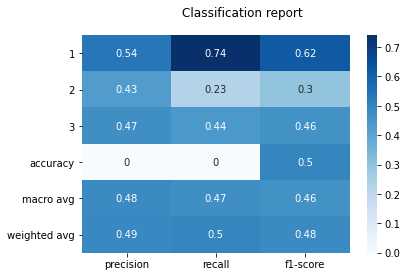

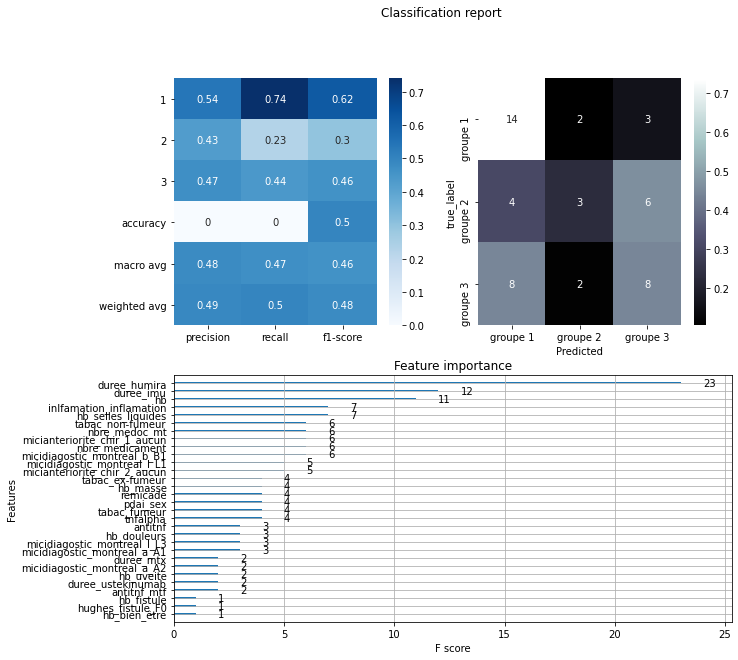

<Figure size 504x432 with 0 Axes>

In [126]:
#entrainement du modéle xgboost sur les métadata:

#del(data["micievolution_montreal_b"])
#del(data["bio_infliximabemie"])
#del(data["bio_crp"])
a.isna().sum()
a=a.sample(frac=1).reset_index(drop=True)

y = pd.DataFrame(data=a, columns=["groupe_cah"])
X = pd.DataFrame(data=a[a.columns.difference(["groupe_cah"])])

X.head()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=40, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape,


dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

params = {
    'max_depth': 4,
    'objective': 'multi:softmax',  
    'num_class': 4,
    'n_gpus': 0,
    'eta': 0.3
,'gamma': 0
,'max_depth': 6,
'max_depth': 3, 'min_child_weight': 3,
'colsample_bytree': 0.6, 'subsample': 0.6,
    'reg_alpha': 0.01
,'silent': 1
,'seed': 0
,'base_score':0.5
}
bst = xgb.train(params, dtrain)
pred = bst.predict(dtest)

from sklearn.metrics import classification_report

clp=classification_report(y_test, pred)

plot_classification_report(clp)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
cm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_actu = pd.Series(y_test.values.flatten(), name='Actual')
y_pred = pd.Series(pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['true_label'], colnames=['Predicted'])
print(df_confusion)
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone',axe=None):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap,ax=axe)
        

        
fig = plt.figure(figsize=[10, 10])     
gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0, 0]) # row 0, col 0


ax2 = plt.subplot(gs[0, 1]) # row 0, col 1

ax3= plt.subplot(gs[1, :])

plot_classification_report(classification_report(y_test, pred),axe=ax1)

plot_confusion_matrix(df_confusion, ['groupe 1', 'groupe 2', 'groupe 3'],axe=ax2)

xgb.plot_importance(bst,max_num_features=30,ax=ax3)
fig.savefig('C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\resultat1\\xgboostdata.png')

In [110]:
datapred['groupe_cah'].value_counts()

1    95
3    89
2    63
Name: groupe_cah, dtype: int64

In [ ]:
data3=data2[["traitement_mtx","traitement_imu","traitement_humira","traitement_ustekinumab","traitement_vedolizumab","goli","infliximab","remicade","groupe_cah"]]
#data3.set_index("groupe_cah",inplace=True)
#sns.heatmap(pd.crosstab(data3.loc[2] ,data3.loc[1] ),cmap="YlGnBu")
#plt.show()
#data["groupe_cah"].value_counts()
dat2=data3.groupby("groupe_cah").sum()
sns.heatmap(dat2,annot=True,cmap="YlGnBu")
plt.savefig("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\image\\resumer_medicament")

In [ ]:
donne_OTUnonnor.csv

In [181]:
datob

micianteriorite_chir_1  \
echantillon                                                       
21_S21_L001                                               aucun   
249_S5_L001                                     resection_grele   
287_S43_L001                                              aucun   
37_S35_L001                                               aucun   
354_S46_L001                                              aucun   
231_S51_L001                                     ileocolectomie   
60_S8_L001                                                aucun   
152_S36_L001                                              aucun   
86_S34_L001                                 chirurgie_perineale   
246_S2_L001                                 chirurgie_perineale   
45_S43_L001                                               aucun   
172_S56_L001                                    resection_grele   
137_S21_L001                                    resection_grele   
124_S8_L001                                               aucun   
14_S14_L001                                               aucun   
259_S15_L001                                              aucun   
305_S61_L001                                              aucun   
340_S32_L001                                              aucun   
248_S4_L001                                     resection_grele   
43_S41_L001                                               aucun   
338_S30_L001                                             _abcès   
1_S1_L001                                                 aucun   
361_S53_L001                                              aucun   
269_S25_L001                                              aucun   
215_S35_L001                                              aucun   
57_S5_L001                                      resection_grele   
54_S2_L001                                                aucun   
133_S17_L001                                chirurgie_perineale   
136_S20_L001                                chirurgie_perineale   
169_S53_L001                                chirurgie_perineale   
279_S35_L001                                chirurgie_perineale   
17_S17_L001                                               aucun   
148_S32_L001                                              aucun   
48_S46_L001                                               aucun   
92_S40_L001                                               aucun   
104_S52_L001                                              aucun   
149_S33_L001                                              aucun   
309_S1_L001                                               aucun   
214_S34_L001                                     drainage_F_cpx   
271_S27_L001                                              aucun   
159_S43_L001                                              aucun   
320_S12_L001                                              aucun   
127_S11_L001                              6_chirurgie_perineale   
276_S32_L001                                              aucun   
99_S47_L001                                               aucun   
181_S1_L001                                                   0   
195_S15_L001                                              aucun   
153_S37_L001                                              aucun   
323_S15_L001                                              aucun   
184_S4_L001                                     resection_grele   
217_S37_L001                                              aucun   
363_S55_L001                                              aucun   
272_S28_L001                                              aucun   
39_S37_L001                                               aucun   
314_S6_L001                                               aucun   
334_S26_L001                                              aucun   
301_S57_L001                                              aucun   
275_S31_L001                                              aucun   
106_S54_L001         

In [180]:
datob.to_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\resultat\\document_inportant\\datop.csv")


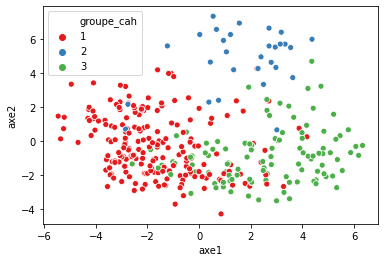

In [452]:
#pd.crosstab(donne_reel_groupe,donne_traiter_groupe,colnames=donne_traiter_groupe)
#donne_reel_groupe.shape
#donne_traiter_groupe.shape



In [164]:
liste=["bio_crp","bio_calprotectine","bio_infliximabemie",'poids_kg',"duree_imu","hb","duree_humira","hemoglobine","plaquettes","leucocytes"]
for i in data.columns:
    if i in liste:
        data[i].astype(float)
        f = plt.figure(figsize=(18, 10))
        gs = f.add_gridspec(2, 3)

        with sns.axes_style("darkgrid"):
            ax = f.add_subplot(gs[0, 0])
            sns.boxplot(x="groupe_cah", y=i, data=data, ax=ax)
            sns.swarmplot(x="groupe_cah", y=i, color="k", size=3, data=data, ax=ax)
        
        with sns.axes_style("white"):
            x=data[i].loc[data["groupe_cah"]==1]
            ax = f.add_subplot(gs[0, 1])
            sns.kdeplot(x, shade=True,ax=ax)
            plt.title('groupe CAH '+str(1))

        with sns.axes_style("ticks"):
            ax = f.add_subplot(gs[0, 2])
            x=data[i].loc[data["groupe_cah"]==2]
            sns.kdeplot(x, shade=True,ax=ax)
            plt.title('groupe CAH '+str(2))
        with sns.axes_style("whitegrid"):
            x=data[i].loc[data["groupe_cah"]==3]
            ax = f.add_subplot(gs[1, 0])
            sns.kdeplot(x, shade=True,ax=ax)
            plt.title('groupe CAH '+str(3))



        plt.show()

In [305]:
bob=pd.read_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\non_normaliser_data.csv",index_col=0)
bob=bob.T
bob.index.name="echantillon"
bob.reset_index(inplace=True)

bob

echantillon  Cluster_161  Cluster_24  Cluster_26  Cluster_20  \
0    100_S48_L001            2           0           2           2   
1    101_S49_L001           29           0          13         425   
2    102_S50_L001          822        6559           6        3970   
3    103_S51_L001         1887           0           0       16533   
4    104_S52_L001         2178           0           0        1457   
..            ...          ...         ...         ...         ...   
351   96_S44_L001          425           0           3         104   
352   97_S45_L001            0           0          12           1   
353   98_S46_L001          525           0          28        6450   
354   99_S47_L001          262           0           4        1111   
355     9_S9_L001            0           1          17           1   

     Cluster_23  Cluster_191  Cluster_560  Cluster_462  Cluster_463  ...  \
0             2            0            0            0            0  ...   
1           742            0            0            0            2  ...   
2           133            0            0            0            0  ...   
3         13097            0            0            0            0  ...   
4           271            0            0            0           18  ...   
..          ...          ...          ...          ...          ...  ...   
351        7415            0            0            0            0  ...   
352           0            0            0            0            0  ...   
353          10            0            0            0            5  ...   
354        8556            0            0           14            9  ...   
355           1          502            0            0            0  ...   

     Cluster_441  Cluster_336  Cluster_236  Cluster_248  Cluster_322  \
0              0            0            0            0            0   
1              0            0            0            0            0   
2              0            0            1            0            0   
3            103            0            0            0            0   
4              2            0         2868            5            0   
..           ...          ...          ...          ...          ...   
351            0            0            0            0            0   
352            0            0            0            0            0   
353            0            2            0            0            0   
354            2            0            0            0            0   
355            0            0            0            0            0   

     Cluster_329  Cluster_429  Cluster_425  Cluster_341  Cluster_349  
0              0            0            2            0            0  
1              0            0            5            0            2  
2             55            0            0            0           12  
3              0            0            0            0            0  
4              0            0            0            0            1  
..           ...          ...          ...          ...          ...  
351            9            0            1            0            0  
352           39            0            3            0            0  
353           18            2           10            0            0  
354            2            0            1            0          153  
355            0            0            8            0            1  

[356 rows x 135 columns]

In [346]:
#table_philr.reset_index(inplace=True)
#df.reset_index(inplace=True)
data
bob=pd.read_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\non_normaliser_data.csv")
bob.rename(columns={"Unnamed: 0":'echantillon'},inplace=True)
bob=pd.merge(data[["echantillon","nbre_medicament"]],bob,on='echantillon')
bob.set_index("echantillon", inplace=True)

bob=bob.groupby("nombre_op_chir").sum()
bob.to_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\DeepMicro\\data\\test_ca.csv")

KeyError: 'nombre_op_chir'

In [344]:
bob

Cluster_161  Cluster_24  Cluster_26  Cluster_20  Cluster_23  \
nombre_op_chir                                                                
0.0                   75453      216213      113581      501138      291260   
1.0                   22162       56823       99177      265263      127526   
2.0                    2984       59387       90669       26914       40887   
3.0                     667       64161        7441        9876        1388   
4.0                    3724          14        3701       41226        8770   

                Cluster_191  Cluster_560  Cluster_462  Cluster_463  \
nombre_op_chir                                                       
0.0                   29219         1418         4657         8094   
1.0                   43581         1270         2389          453   
2.0                   47168         1398           47           85   
3.0                    5372           99            0            4   
4.0                    1831          234          879           85   

                Cluster_305  ...  Cluster_441  Cluster_336  Cluster_236  \
nombre_op_chir               ...                                          
0.0                      38  ...         2937        15954        14501   
1.0                    2052  ...         3198         5138        14447   
2.0                    5738  ...          237          804            6   
3.0                      15  ...           68            0            1   
4.0                       1  ...          107          633            0   

                Cluster_248  Cluster_322  Cluster_329  Cluster_429  \
nombre_op_chir                                                       
0.0                     199         2003         5803          988   
1.0                      28          829         3281          916   
2.0                      84         1835         1460         2165   
3.0                   24643           16         4766            2   
4.0                      51           35           34          357   

                Cluster_425  Cluster_341  Cluster_349  
nombre_op_chir                                         
0.0                    8846        13149         3656  
1.0                    3653            2         6933  
2.0                    4251            4          137  
3.0                    1019            0          626  
4.0                     760            1          527  

[5 rows x 134 columns]

      echantillon  nombre_op_chir       tabac micianteriorite_chir_1  \
0     21_S21_L001             0.0  non-fumeur                  aucun   
1    155_S39_L001             0.0      fumeur                  aucun   
2     118_S2_L001             4.0      fumeur    chirurgie_perineale   
3     186_S6_L001             0.0      fumeur                  aucun   
4    369_S61_L001             3.0   ex-fumeur      drainage_fistulRV   
..            ...             ...         ...                    ...   
330  325_S17_L001             NaN         NaN                    NaN   
331  166_S50_L001             NaN         NaN                    NaN   
332  207_S27_L001             NaN         NaN                    NaN   
333  223_S43_L001             NaN         NaN                    NaN   
334  206_S26_L001             NaN         NaN                    NaN   

     Cluster_161  Cluster_24  Cluster_26  Cluster_20  Cluster_23  Cluster_191  \
0            306         176           0        3055  

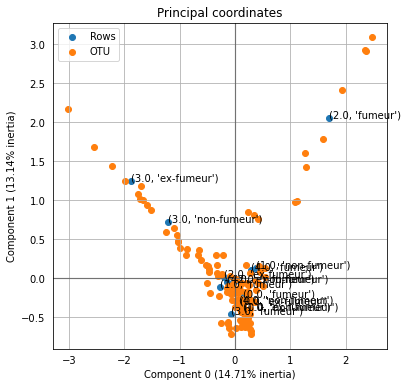

In [96]:
#utilisation de prince afin de faire une CA sur les metadata et la table OTU 
#label tester tabac,micianteriorite_chir_1
label=["nombre_op_chir","tabac"]

x=pd.merge(metadata[["echantillon","nombre_op_chir","tabac","micianteriorite_chir_1"]],bob,on="echantillon")
#importation de la colone de metadata
print(x)
del(x["echantillon"])


#table_philr["micianteriorite_chir_1"]=table_philr["micianteriorite_chir_1"].apply(lambda x: "operation" if x != "aucun" else x)
x = x.groupby(label).mean()
print(x)

x = scaling(x,"MinMaxScaler") 

ca = prince.CA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42 )
x.columns.rename('OTU', inplace=True)


ca = ca.fit(x)

ax = ca.plot_coordinates(
   X=x,
   ax=None,
   figsize=(6, 6),
   x_component=0,
   y_component=1,
   show_row_labels=True,
   show_col_labels=False,
    
)
if False:
    #df.reset_index(inplace=True)
    x=pd.merge(metadata[["echantillon",label]],df,on="echantillon")
    #importation de la colone de metadata
    #table_philr.reset_index(inplace=True)
    del(x["echantillon"])


    #table_philr["micianteriorite_chir_1"]=table_philr["micianteriorite_chir_1"].apply(lambda x: "operation" if x != "aucun" else x)
    x = x.groupby(x[label]).mean()


    x = scaling(x,"MinMaxScaler") 

    ca = prince.CA(
        n_components=2,
        n_iter=3,
        copy=True,
        check_input=True,
        engine='auto',
        random_state=42 )
    x.columns.rename('OTU', inplace=True)
    x.index.rename('col', inplace=True)

    ca = ca.fit(x)

    ax = ca.plot_coordinates(
       X=x,
       ax=None,
       figsize=(6, 6),
       x_component=0,
       y_component=1,
       show_row_labels=True,
       show_col_labels=True
        
        
    )

In [25]:
data

echantillon  Cluster_161  Cluster_24  Cluster_26  Cluster_20  \
0     21_S21_L001     1.103571    1.079440   -1.520365    0.786801   
1    155_S39_L001     1.052499   -0.693556   -0.028814    0.724273   
2     118_S2_L001    -1.224194   -0.733159    0.280461    0.393172   
3     186_S6_L001    -0.827998    0.300369    1.484961   -1.408479   
4    369_S61_L001     1.070552    2.682335    0.735673   -1.349913   
..            ...          ...         ...         ...         ...   
319  325_S17_L001     0.480701    0.354340   -0.541672    0.713921   
320  166_S50_L001     1.442426   -0.410714    1.107266    1.006871   
321  207_S27_L001     0.141909   -0.726502    0.071018    0.410366   
322  223_S43_L001     0.152206   -0.862876   -0.357024    0.446945   
323  206_S26_L001     1.278863   -0.726335   -0.462246    0.168125   

     Cluster_23  Cluster_191  Cluster_560  Cluster_462  Cluster_463  ...  \
0      1.545348    -0.754825    -0.789887    -0.432207    -0.703452  ...   
1      0.856405    -0.681024    -0.014983    -0.893350    -1.197627  ...   
2     -0.851114     2.251909     1.565189    -0.460797     0.816396  ...   
3     -0.518077     1.907161    -0.098175     0.345965     0.130461  ...   
4      0.747518     3.069266     1.606280    -0.501847    -0.778081  ...   
..          ...          ...          ...          ...          ...  ...   
319   -0.202683    -0.526202    -0.388718     0.019107     1.336415  ...   
320   -1.461129     0.062059     0.739795    -0.453413    -0.726177  ...   
321    1.280400    -0.447696    -0.710577    -0.342983    -0.607837  ...   
322    1.043566    -0.626428    -1.036795    -0.709977    -1.001119  ...   
323    0.704892    -0.447477     0.071960    -0.488080    -0.763327  ...   

     traitement_ustekinumab  duree_ustekinumab  traitement_vedolizumab  goli  \
0                       0.0                0.0                     0.0   0.0   
1                       0.0                0.0                     0.0   0.0   
2                       0.0                0.0                     0.0   0.0   
3                       1.0              615.0                     1.0   0.0   
4                       0.0                0.0                     0.0   0.0   
..                      ...                ...                     ...   ...   
319                     NaN                NaN                     NaN   NaN   
320                     NaN                NaN                     NaN   NaN   
321                     NaN                NaN                     NaN   NaN   
322                     NaN                NaN                     NaN   NaN   
323                     NaN                NaN                     NaN   NaN   

     infliximab  remicade  maladie       patient_symp  nbre_medicament  \
0           0.0       0.0    crohn  non_symptomatique                2   
1           0.0       0.0    crohn  non_symptomatique                1   
2           0.0       0.0    crohn  non_symptomatique                3   
3           0.0       0.0    crohn  non_symptomatique                5   
4           1.0       0.0    crohn      symptomatique                2   
..          ...       ...      ...                ...              ...   
319         NaN       NaN    crohn  non_symptomatique                0   
320         NaN       NaN      SII  non_symptomatique                0   
321         NaN       NaN      RCH  non_symptomatique                0   
322         NaN       NaN      RCH  non_symptomatique                0   
323         NaN       NaN      RCH  non_symptomatique                0   

     groupe_cah  
0             1  
1             1  
2             3  
3             2  
4             3  
..          ...  
319           1  
320           1  
321           1  
322           1  
323           1  

[324 rows x 194 columns]

In [17]:
#table_phil.set_index(["echantillon"],inplace=True)
#del(table_phil["patient_symp"])
#table_phil
a=classification_automatique(table_phil)
#faire le reverse scaling pour la table de donnée de philr, mis a diposition "https://rdrr.io/bioc/philr/man/philrInv.html"
a.regroupement_CAH_Kmeans(nbre_clusters=3,decoupage_hauteur=8)

NameError: name 'table_phil' is not defined

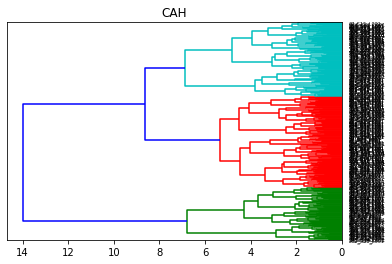

186_S6_L001     1
53_S1_L001      1
112_S60_L001    1
295_S51_L001    1
200_S20_L001    1
               ..
4_S4_L001       1
317_S9_L001     1
369_S61_L001    1
146_S30_L001    1
126_S10_L001    1
Name: echantillon, Length: 81, dtype: int64
70_S18_L001     1
65_S13_L001     1
269_S25_L001    1
354_S46_L001    1
12_S12_L001     1
               ..
108_S56_L001    1
221_S41_L001    1
124_S8_L001     1
315_S7_L001     1
6_S6_L001       1
Name: echantillon, Length: 140, dtype: int64
368_S60_L001    1
209_S29_L001    1
338_S30_L001    1
352_S44_L001    1
198_S18_L001    1
               ..
118_S2_L001     1
206_S26_L001    1
334_S26_L001    1
61_S9_L001      1
157_S41_L001    1
Name: echantillon, Length: 114, dtype: int64
           3         2         1
0   0.234384  0.236942  0.312733
1  -0.080550 -0.096856 -0.176969
2  -0.629212 -0.533899 -0.459257
3   0.169662  0.133792  0.241392
4  -0.400096 -0.353263 -0.421434
5   0.061858  0.112321 -0.204077
6  -0.977306 -0.837733 -0.871864
7   0.13

In [21]:
#creation d'une instance pour la classification
a=classification_automatique(df)
#utilisation de la methode de classification, il faut utiliser le decoupage_hauteur afin de definir les groupes 
b=a.CAH(decoupage_hauteur=8,color_threshold=8)
label="echantillon"
#afficher la composition des labels par groupes 
for i in  b.index.unique():
    print(b.loc[i]["echantillon"].value_counts())

#utiliser la ligne dessous si jamais la colonne echantillon n'est pas au niveau de l'index
#philr.set_index("Unnamed: 0",inplace=True)
#morceau de code permettant d'afficher le profil moyen des OTU pour chacun des trois groupes montrée par le CAH
path=""
dictio={}
otu_type=True
metadata_groupe=False
# permet d'afficher la moyenne de chaque feature par groupes 
if otu_type:
    for i in  b.index.unique():
        dictio={i:df.loc[b.loc[i]["echantillon"]].mean(),**dictio}
    resultat=pd.DataFrame(dictio)
    print (resultat)
# permet de creer un fichier excel contenant les information des metadata des samples regrouper par groupes
if metadata_groupe:
    for i in b.index.unique():
        groupe=b.loc[i]["echantillon"]
        groupe=pd.merge(groupe1,metadata,on="echantillon")
        print("groupe"+str(i), groupe)
        groupe.to_excel(path+i+".xlsx")

In [186]:

num_epochs = 2000
batch_size = 40
learning_rate = 1e-3
pourcentage_cross_over=0.2
patience=20
data_dir="C:\\Users\\franc\\Documents\\stage\\DeepMicro\\DeepMicro\\data\\philrs.csv"
bob=pd.read_csv(data_dir,header=None)
dataframe = scaling(bob,"MinMaxScaler") 
pourcentage_cross_over=int((1-pourcentage_cross_over)*dataframe.shape[0])
xtrain=dataframe.iloc[0:pourcentage_cross_over]
xtest=dataframe.iloc[pourcentage_cross_over:]
trainset = torch.from_numpy(np.array(xtrain)).float()
valset = torch.from_numpy(np.array(xtest)).float()
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,shuffle=True)
cuda0 = torch.device('cuda:0')

model = autoencoder().to(cuda0)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, patience=15, verbose=True)
model, train_loss, valid_loss = train_model(model, batch_size, patience, num_epochs)



[   1/2000] train_loss: 0.28193 valid_loss: 0.25449
Validation loss decreased (inf --> 0.254494).  Saving model ...
[   2/2000] train_loss: 0.22345 valid_loss: 0.17788
Validation loss decreased (0.254494 --> 0.177878).  Saving model ...
[   3/2000] train_loss: 0.13800 valid_loss: 0.10019
Validation loss decreased (0.177878 --> 0.100192).  Saving model ...
[   4/2000] train_loss: 0.08005 valid_loss: 0.05810
Validation loss decreased (0.100192 --> 0.058103).  Saving model ...
[   5/2000] train_loss: 0.05022 valid_loss: 0.04374
Validation loss decreased (0.058103 --> 0.043743).  Saving model ...
[   6/2000] train_loss: 0.04043 valid_loss: 0.03862
Validation loss decreased (0.043743 --> 0.038622).  Saving model ...
[   7/2000] train_loss: 0.03778 valid_loss: 0.03713
Validation loss decreased (0.038622 --> 0.037127).  Saving model ...
[   8/2000] train_loss: 0.03560 valid_loss: 0.03681
Validation loss decreased (0.037127 --> 0.036813).  Saving model ...
[   9/2000] train_loss: 0.03450 valid

[  78/2000] train_loss: 0.02257 valid_loss: 0.02323
Validation loss decreased (0.023388 --> 0.023233).  Saving model ...
[  79/2000] train_loss: 0.02227 valid_loss: 0.02299
Validation loss decreased (0.023233 --> 0.022990).  Saving model ...
[  80/2000] train_loss: 0.02278 valid_loss: 0.02295
Validation loss decreased (0.022990 --> 0.022954).  Saving model ...
[  81/2000] train_loss: 0.02195 valid_loss: 0.02284
Validation loss decreased (0.022954 --> 0.022841).  Saving model ...
[  82/2000] train_loss: 0.02128 valid_loss: 0.02293
EarlyStopping counter: 1 out of 20
[  83/2000] train_loss: 0.02148 valid_loss: 0.02257
Validation loss decreased (0.022841 --> 0.022569).  Saving model ...
[  84/2000] train_loss: 0.02156 valid_loss: 0.02259
EarlyStopping counter: 1 out of 20
[  85/2000] train_loss: 0.02102 valid_loss: 0.02238
Validation loss decreased (0.022569 --> 0.022379).  Saving model ...
[  86/2000] train_loss: 0.02048 valid_loss: 0.02243
EarlyStopping counter: 1 out of 20
[  87/2000] t

[ 156/2000] train_loss: 0.01466 valid_loss: 0.01695
EarlyStopping counter: 1 out of 20
[ 157/2000] train_loss: 0.01459 valid_loss: 0.01666
EarlyStopping counter: 2 out of 20
[ 158/2000] train_loss: 0.01415 valid_loss: 0.01645
Validation loss decreased (0.016649 --> 0.016455).  Saving model ...
[ 159/2000] train_loss: 0.01432 valid_loss: 0.01677
EarlyStopping counter: 1 out of 20
[ 160/2000] train_loss: 0.01453 valid_loss: 0.01648
EarlyStopping counter: 2 out of 20
[ 161/2000] train_loss: 0.01453 valid_loss: 0.01654
EarlyStopping counter: 3 out of 20
[ 162/2000] train_loss: 0.01411 valid_loss: 0.01652
EarlyStopping counter: 4 out of 20
[ 163/2000] train_loss: 0.01445 valid_loss: 0.01653
EarlyStopping counter: 5 out of 20
[ 164/2000] train_loss: 0.01404 valid_loss: 0.01633
Validation loss decreased (0.016455 --> 0.016331).  Saving model ...
[ 165/2000] train_loss: 0.01419 valid_loss: 0.01619
Validation loss decreased (0.016331 --> 0.016192).  Saving model ...
[ 166/2000] train_loss: 0.01

[ 240/2000] train_loss: 0.01131 valid_loss: 0.01395
EarlyStopping counter: 1 out of 20
[ 241/2000] train_loss: 0.01114 valid_loss: 0.01388
EarlyStopping counter: 2 out of 20
[ 242/2000] train_loss: 0.01111 valid_loss: 0.01381
Validation loss decreased (0.013823 --> 0.013810).  Saving model ...
[ 243/2000] train_loss: 0.01092 valid_loss: 0.01383
EarlyStopping counter: 1 out of 20
[ 244/2000] train_loss: 0.01104 valid_loss: 0.01387
EarlyStopping counter: 2 out of 20
[ 245/2000] train_loss: 0.01101 valid_loss: 0.01368
Validation loss decreased (0.013810 --> 0.013681).  Saving model ...
[ 246/2000] train_loss: 0.01082 valid_loss: 0.01391
EarlyStopping counter: 1 out of 20
[ 247/2000] train_loss: 0.01084 valid_loss: 0.01378
EarlyStopping counter: 2 out of 20
[ 248/2000] train_loss: 0.01091 valid_loss: 0.01367
Validation loss decreased (0.013681 --> 0.013671).  Saving model ...
[ 249/2000] train_loss: 0.01064 valid_loss: 0.01374
EarlyStopping counter: 1 out of 20
[ 250/2000] train_loss: 0.01

In [187]:
liste=[]
for i in range(dataframe.shape[0]):
    img=torch.from_numpy(np.array(dataframe.iloc[i])).float()
    img = Variable(img).to(cuda0)
    output=model(img,encodeur=True)
    liste.append(output.tolist())
ar = np.array(liste)
df = pd.DataFrame(ar, index = dataframe.index)
df    
#loss = criterion(output, img)


0         1         2         3         4         5         6   \
0    0.933784  0.523377  0.569878  0.445979 -0.152872  0.078277 -0.257981   
1    0.684327  0.288217  0.477250  0.299250 -0.614981  0.453429  0.466527   
2    0.257728  0.521315  0.595228  0.727049 -0.914582  0.610204  0.005195   
3    0.386913  0.251674  0.300552  0.420035 -0.720243  0.101023  0.233246   
4    1.088170  0.294458  0.631993  0.467256 -0.467338  0.500946 -0.108139   
..        ...       ...       ...       ...       ...       ...       ...   
351  0.060151  0.183568  0.495893  0.601321 -0.482618  0.555391  0.725715   
352  0.593002  0.585528  0.268732  0.684455 -0.823770  0.330991  0.365859   
353  0.532078  0.285196  0.278923  0.315976 -0.807196  0.397855 -0.039219   
354  0.743305  0.413221  0.385870  0.571868 -0.537412  0.049065  0.124359   
355  0.272795  0.371939  0.218459  0.826630 -0.931041  0.199122  0.745267   

           7         8         9   ...        22        23        24  \
0   -0.589752  1.406622  0.842053  ... -0.149839  0.093617  0.009011   
1    0.293322  1.256572  0.795877  ...  0.172795  0.043826 -0.209559   
2   -0.228015  1.131765  0.592513  ...  0.088108 -0.780035 -0.245796   
3   -0.183144  0.998096  0.551870  ... -0.021454 -0.278705 -0.426597   
4   -0.135340  1.257194  0.637875  ...  0.030686 -0.236078 -0.106523   
..        ...       ...       ...  ...       ...       ...       ...   
351 -0.570545  0.782806  0.993172  ...  0.408580 -0.135627 -0.073105   
352  0.012014  1.180670  0.849857  ... -0.282996 -0.282608  0.368475   
353 -0.104859  1.197892  0.508458  ... -0.063106 -0.198223 -0.538333   
354 -0.343064  1.119915  0.643322  ... -0.053830 -0.291504  0.013663   
355 -0.146705  0.972451  0.739947  ...  0.186671 -0.386348  0.103574   

           25        26        27        28        29        30        31  
0    0.697056  0.122287 -1.106087  0.449170  1.037130  0.036647 -0.916936  
1    0.540613  0.468974 -0.994831  0.078580  1.319654 -0.313711 -0.835178  
2   -0.043106  0.084736 -0.771402  0.078606  0.958864  0.132231 -0.012739  
3    0.049098 -0.285495 -0.718834  0.195591  0.835515  0.282218 -0.413619  
4    0.237174 -0.145376 -0.871578  0.051822  0.883148  0.150369 -0.571798  
..        ...       ...       ...       ...       ...       ...       ...  
351  0.072269 -0.296140 -0.552236  0.172468  1.069455 -0.002045 -0.291074  
352  0.151516  0.083041 -1.490993 -0.120911  1.022539 -0.233589 -0.885395  
353  0.214338  0.239899 -0.925893  0.139061  0.967725  0.081647 -0.406763  
354  0.353159 -0.068909 -0.995891  0.506684  0.866018  0.107249 -0.599144  
355 -0.046898 -0.653803 -0.971187 -0.151704  0.809847  0.400747 -0.607384  

[356 rows x 32 columns]

In [35]:
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
similarities = euclidean_distances(df)
similarities
mds =MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=4)
pos = mds.fit(similarities).embedding_

In [49]:
import pandas as pd
#boby.reset_index(inplace=True)
#boby=pd.merge(boby,metadata[["echantillon","maladie"]],on="echantillon")

X=np.matrix(boby.iloc[:,:-1])
Y=LabelEncoder().fit_transform(np.array(boby.iloc[:,-1]))
X

matrix([[ 0.41364416, -0.26630053, -0.42220762, ...,  0.34865636,
          0.61213475, -0.49238032],
        [ 0.1783976 ,  0.27067035, -0.41225284, ...,  0.30624673,
          0.170586  , -0.26731247],
        [ 0.2528272 ,  0.05425071, -0.50632334, ...,  0.14923671,
          0.48046201, -0.02899812],
        ...,
        [ 0.10362792, -0.25786242, -0.47707394, ...,  0.16945812,
          0.26797289, -0.40479952],
        [ 0.23668124, -0.03017576, -0.43009946, ...,  0.19875854,
          0.04111476, -0.15618204],
        [-0.11377919, -0.00226783, -0.86104667, ..., -0.0854027 ,
          0.5291537 , -0.11658733]])

In [50]:
#partie xgboost 
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV ,KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder

print(Y.shape)
X.shape

(335,)


(335, 32)

In [52]:
from sklearn.metrics import accuracy_score
modele=XGBClassifier()

kfold = KFold(n_splits=5, shuffle=True, random_state=7)
for train_index,test_index in kfold.split(X):
    x_train,x_test=X[train_index],X[test_index]
    y_train,y_test=Y[train_index],Y[test_index]
eval_set=[[(x_test,y_test)]]
dtrain = xgb.DMatrix(x_train, label=y_train)
modele.fit(x_train,y_train,eval_metric="auc",verbose=True)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [56]:
#modele.fit(x_train,y_train,eval_metric="auc",verbose=True)
#modele=XGBClassifier()

param = {'max_depth': 10, 'eta': 0.012, 'eval_metric':['auc'],'gamma':10,"objective":"multi:softmax","n_estimateurs":1000}
modele=XGBClassifier(param)
eval_set=[(x_train,y_train),(x_test,y_test)]
modele.fit(x_train,y_train,eval_set=eval_set,verbose=True)

ValueError: y contains previously unseen labels: [5, 6]

In [ ]:
y_pred = modele.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [60]:
param_grid = { 'reg_alpha':[1e-5, 1e-2, 0.1, 1]}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


TypeError: estimator should be an estimator implementing 'fit' method, autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=61, out_features=42, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=42, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=42, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=42, out_features=61, bias=True)
  )
) was passed

In [114]:
#premierement Tune max_depth and min_child_weight
#deuxiement Tune gamma
#troisiement Tune subsample and colsample_bytree
#quatiement Tuning Regularization Parameters
#cinquiement Reducing Learning Rate
#utilisation de cross validation
def choisirhyperparametre(train,test,objective="multi:softmax",param={},description=False,plot=False):
    bestparam={}
    if not param :
        param={'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2),'subsample':[i/10.0 for i in range(5,10)],'colsample_bytree':[i/10.0 for i in range(5,10)],'reg_alpha':[1e-5, 1e-2, 0.1, 1],'gamma':[i/10.0 for i in range(0,5)]}
    model = XGBClassifier(objective=objective)
    
    for i in [['max_depth','min_child_weight'],['gamma'],['subsample','colsample_bytree'],['reg_alpha']]:
        param_grid={}
        for v in i:
            param_grid.update({v:param[v]})
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
        grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
        grid_result = grid_search.fit(train, test)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        bestparam.update(grid_result.best_params_)
        if description:
            means = grid_result.cv_results_['mean_test_score']
            stds = grid_result.cv_results_['std_test_score']
            params = grid_result.cv_results_['params']
            for mean, stdev, param in zip(means, stds, params):
                print("%f (%f) with: %r" % (mean, stdev, param))

        # plot ne fonctionne pas pour le moment 
        if plot:#permet de decider d'afficher les different plot
            plt.errorbar(subsample, means, yerr=stds)
            plt.title("XGBoost subsample vs Log Loss")
            plt.xlabel('subsample')
            plt.ylabel('train')  
    return bestparam



In [115]:
bestparam=choisirhyperparametre(X,Y )

C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best: 0.716418 using {'max_depth': 5, 'min_child_weight': 3}


C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best: 0.716418 using {'gamma': 0.4}


C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best: 0.725373 using {'colsample_bytree': 0.5, 'subsample': 0.9}


C:\Users\franc\Documents\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best: 0.707463 using {'reg_alpha': 1}


In [63]:
def modelfit(modele,data,target ,colunspredict ,useTrainCV=True, cv_folds=5, early_stopping_rounds=60):
    
    if useTrainCV:
        xgb_param = modele.get_xgb_params()
        train = xgb.DMatrix(data[colunspredict].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, train, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        modele.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    eval_set=[(x_train,y_train),(x_test,y_test)]
    modele.fit(train[colunspredict], train[target],eval_metric='auc',eval_set=eval_set,verbose=True)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[colunspredict])
    dtrain_predprob = alg.predict_proba(dtrain[colunspredict])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(modele.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [65]:
modele=XGBClassifier()
print(modele.get_xgb_params())
modele.set_params(bestparam)
print(modele.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


TypeError: set_params() takes 1 positional argument but 2 were given

In [102]:
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
hotenco = OneHotEncoder(handle_unknown='ignore')
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(boby["tabac"])
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[0 2 1 0 0 1 0 2 2 1 0 0 2 2 2 2 2 1 2 2 0 2 0 2 1 0 1 1 2 2 2 1 2 1 0 1 2
 2 1 1 0 0 2 1 0 2 0 0 2 2 2 0 0 1 2 2 1 1 0 0 0 1 1 2 1 1 0 2 1 1 1 2 0 1
 0 1 2 2 2 2 1 0 2 2 2 2 0 0 1 1 2 2 2 2 0 2 0 0 0 1 1 0 2 2 2 2 2 1 2 2 1
 0 1 2 1 0 1 0 0 0 2 0 0 0 0 0 0 2 2 2 1 1 0 2 2 2 0 2 2 0 0 2 2 2 1 0 2 2
 2 1 0 2 2 2 2 2 2 2 0 0 2 0 2 1 2 1 2 1 1 2 0 0 1 2 0 2 2 2 2 1 2 2 2 0 2
 2 0 1 2 1 0 1 0 0 0 1 2 2 1 1 2 0 1 2 1 2 1 2 0 1 0 2 0 1 0 2 2 2 2 2 0 2
 0 2 2 1 1 2 2 0 1 2 2 2 1 2 2 2]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]


In [122]:
#x=np.array(boby.iloc[:, 0:-1])
#dtrain = xgb.DMatrix(x,onehot_encoded )
bestparam['objective'] = 'multi:softmax'
num_round = 10
bst = xgb.train(bestparam, dtrain, num_round)
xgb.plot_importance(bst)

XGBoostError: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.

In [171]:
import torch
import matplotlib
from sklearn.datasets import load_iris
from fastsom import *

In [172]:
xtrain=df
x = torch.from_numpy(np.array(xtrain)).float()
Y = torch.from_numpy(y).float()
train_loader = torch.utils.data.DataLoader(trainset)

NameError: name 'df' is not defined

In [173]:
import pandas as pd
import SimpSOM as sps
from sklearn.cluster import KMeans
import numpy as np

In [174]:
dataframe

n1        n2        n3        n4        n5        n6  \
echantillon                                                                
352_S44_L001  0.858739  0.514277 -1.080884 -0.842007 -1.526962  0.948032   
342_S34_L001  0.860489  0.828304 -1.201253 -0.586532  0.536972  0.022760   
172_S56_L001  0.162314 -0.397100 -1.608158  0.562687  0.828565  0.432570   
206_S26_L001  0.923422  1.190361 -0.371028  0.100640  0.952707 -0.820523   
17_S17_L001  -1.809878 -1.406848 -0.716821 -0.807359 -0.536032 -1.137819   
...                ...       ...       ...       ...       ...       ...   
282_S38_L001 -0.677761 -0.360317 -0.246647 -0.605493 -1.596509 -2.184503   
254_S10_L001  0.643129  1.548901 -1.219549 -0.396705  0.619285 -0.495370   
11_S11_L001   0.479513  1.040796  1.606062 -0.084048  0.233512 -0.714056   
56_S4_L001   -1.773521 -0.779304 -0.781772 -0.009195 -1.286381 -1.964927   
343_S35_L001 -2.307274 -1.370011 -0.863267  0.345562  0.663748 -0.232322   

                    n7        n8        n9       n10  ...       n52       n53  \
echantillon                                           ...                       
352_S44_L001  1.199421  1.337590  0.929328  0.097250  ...  0.244290  1.085111   
342_S34_L001  1.019468 -0.972533  0.763257 -1.208984  ... -0.284600  0.852262   
172_S56_L001  0.661303 -0.829085  0.461198  0.596181  ... -0.408213  0.812537   
206_S26_L001  1.086493 -1.138517  0.818947 -0.768737  ...  0.154495  1.111793   
17_S17_L001  -0.243797 -0.329595 -0.301295 -1.620185  ... -0.459566 -0.256607   
...                ...       ...       ...       ...  ...       ...       ...   
282_S38_L001 -1.550034 -0.741147 -1.408524  0.153320  ... -0.339770 -1.032421   
254_S10_L001  0.668372  0.425307  0.474711 -0.354415  ... -0.604882 -1.619118   
11_S11_L001   0.020382 -1.369563  0.328095 -0.714781  ... -0.356644  0.543245   
56_S4_L001   -2.637623 -1.035994 -2.330130 -0.302380  ... -1.122985 -1.552673   
343_S35_L001 -0.318583 -0.790728  0.208089 -1.428547  ... -1.112314 -1.804201   

                   n54       n55       n56       n57       n58       n59  \
echantillon                                                                
352_S44_L001  0.949762  0.666897  0.847018  1.057916 -0.230965 -0.443606   
342_S34_L001  0.050069  1.302546 -1.789683 -0.665055  1.101736 -1.256883   
172_S56_L001  0.769832  1.114773 -2.069486 -1.456100  1.330440 -1.038534   
206_S26_L001  0.424851  0.718272  1.078115  1.266311 -1.031918 -0.455181   
17_S17_L001   1.592717 -0.147475  0.798066  0.941329  0.250207  0.458392   
...                ...       ...       ...       ...       ...       ...   
282_S38_L001 -0.216186 -0.018501  0.258361 -0.493837 -0.167346  0.428514   
254_S10_L001 -2.312063 -2.427384  0.856810  1.423023 -0.442724 -0.845201   
11_S11_L001   0.167020  0.421935  0.372019  0.747696  0.935914 -0.804842   
56_S4_L001    0.533454  0.843094  0.074870 -1.213362  0.606976  1.295135   
343_S35_L001  0.786708 -1.617471 -0.222823  0.254030  0.440628 -0.941626   

                   n60       n61  
echantillon                       
352_S44_L001 -0.804729  1.000686  
342_S34_L001  1.227681  1.272709  
172_S56_L001 -0.713304 -0.938496  
206_S26_L001 -0.172917  0.884759  
17_S17_L001   1.514226  0.855054  
...                ...       ...  
282_S38_L001 -0.761791 -0.147720  
254_S10_L001  1.208667  1.340745  
11_S11_L001   0.570466 -0.679122  
56_S4_L001    0.047959 -0.679122  
343_S35_L001  0.480534 -1.684507  

[324 rows x 61 columns]

Periodic Boundary Conditions active.
The weights will be initialised randomly.
Training SOM... done!


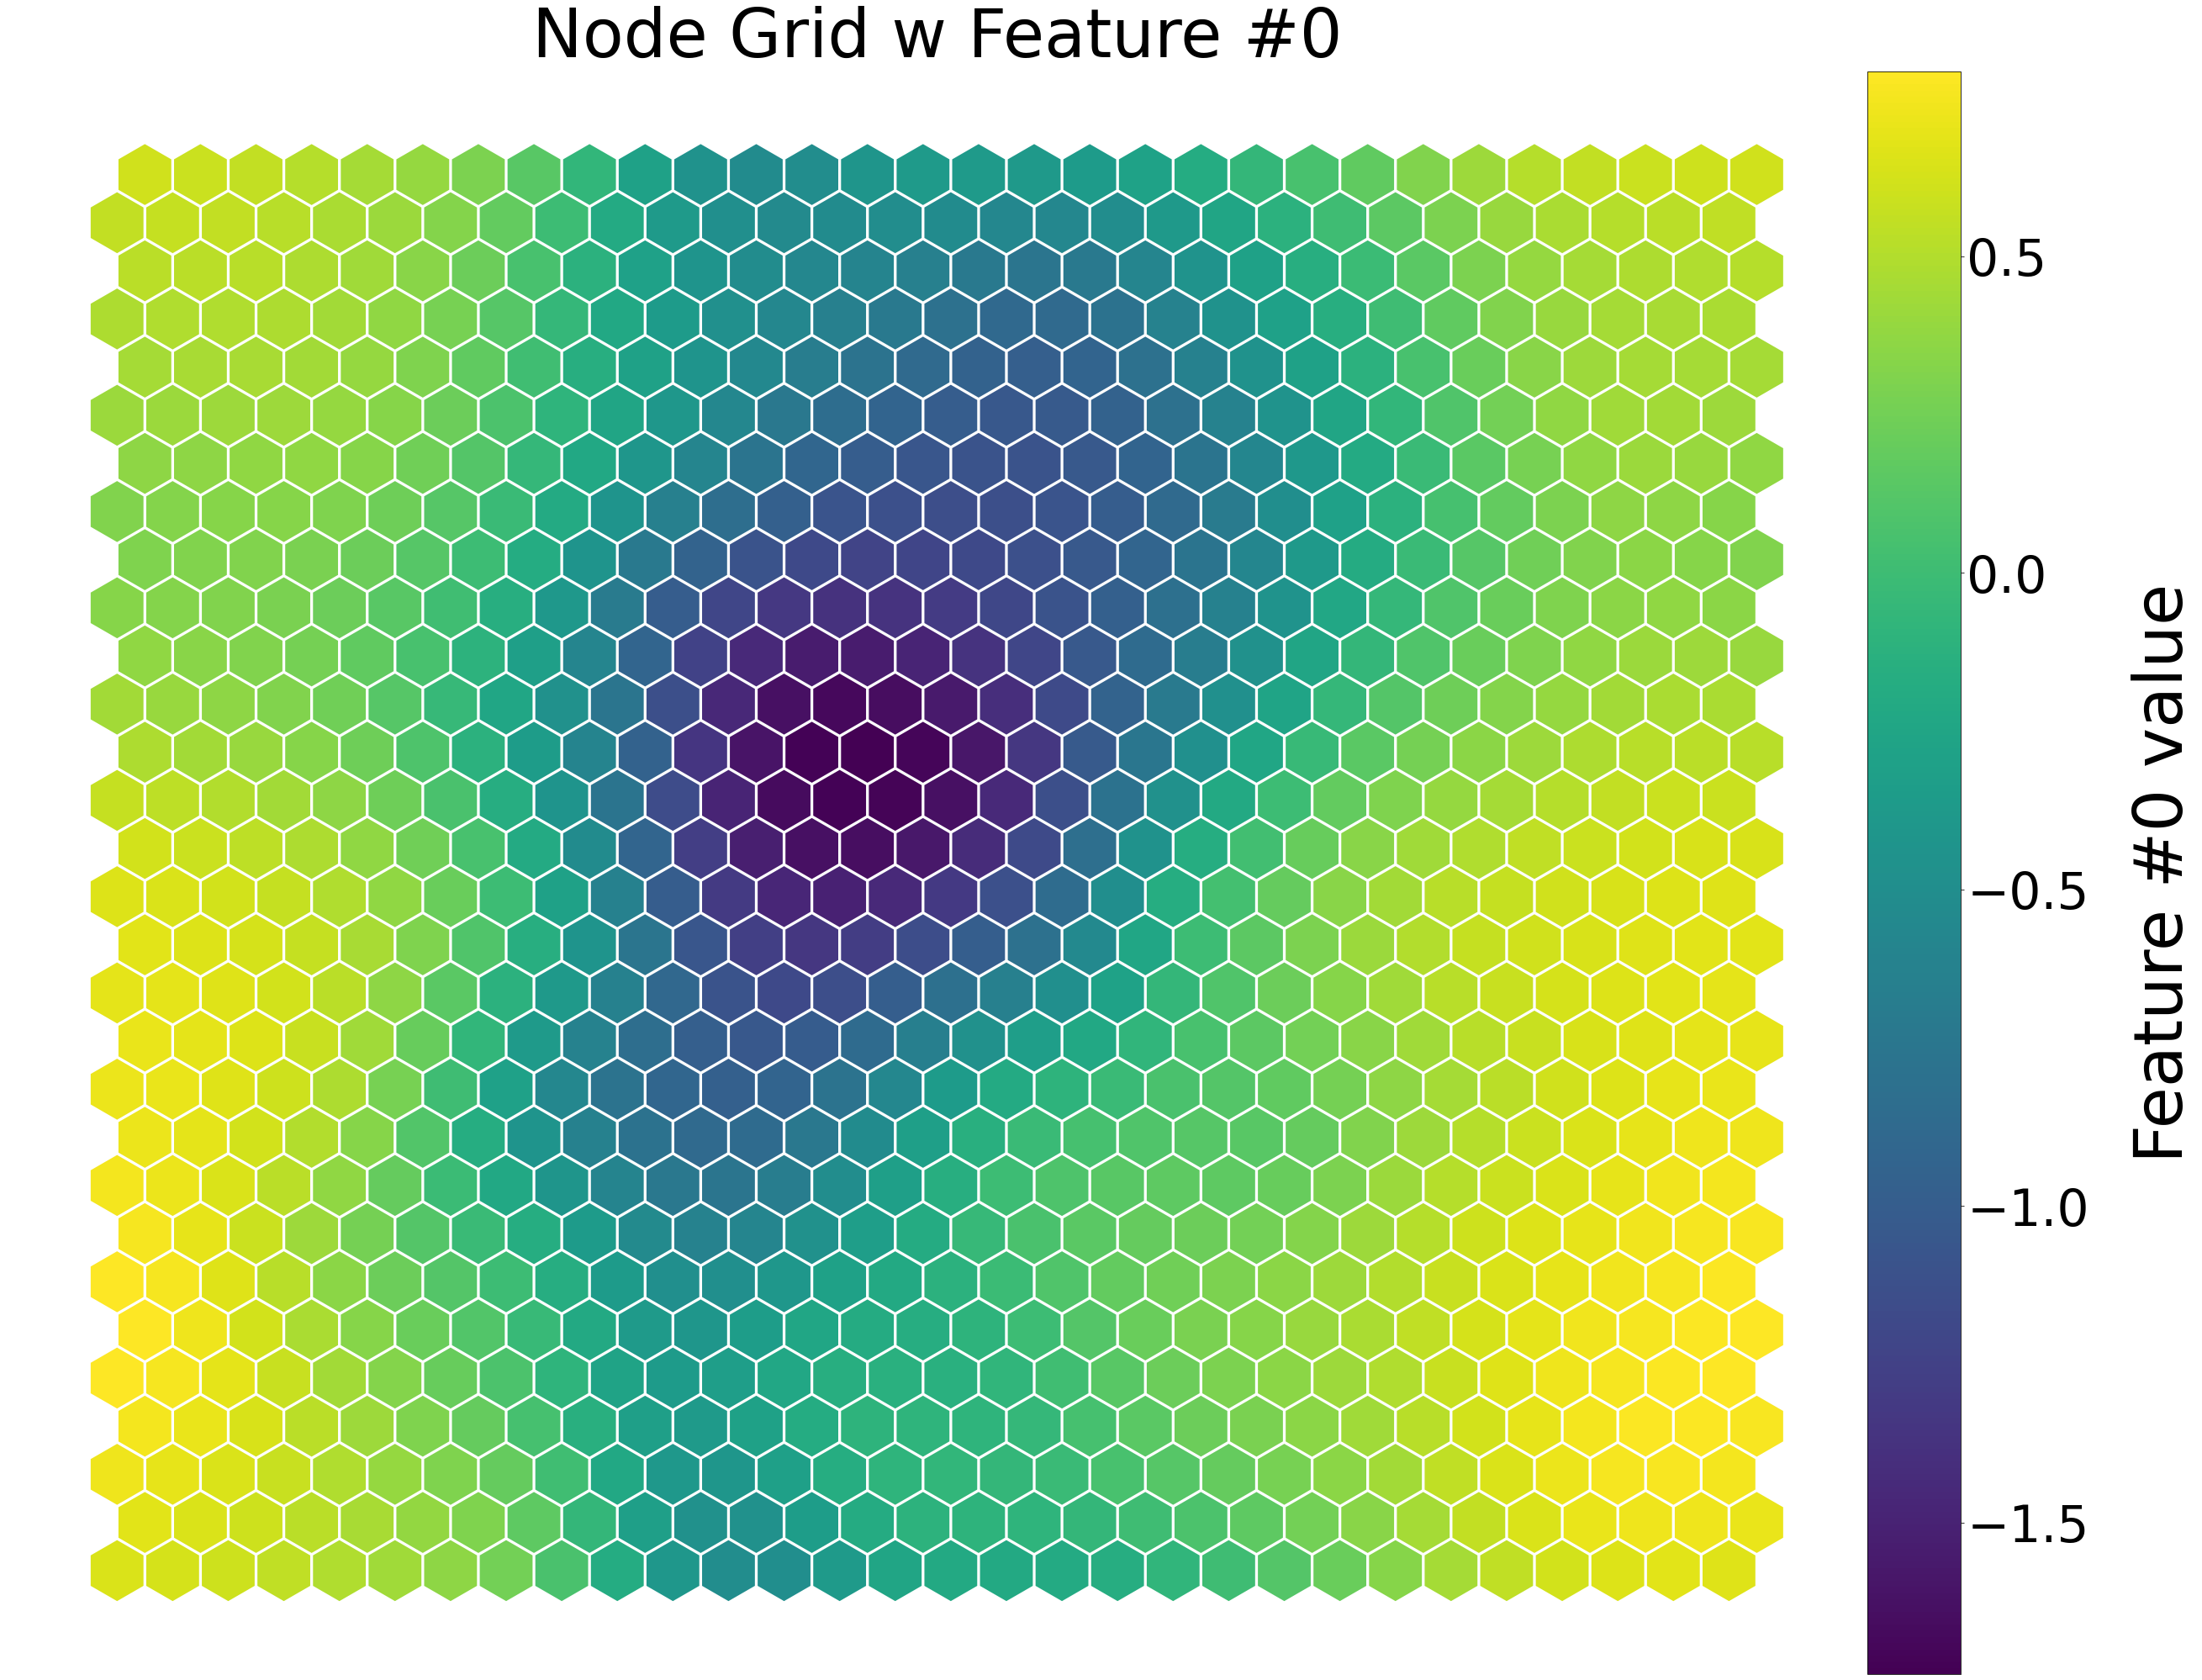

In [175]:

net = sps.somNet(30, 30, np.array(dataframe),PBC=True)
net.train(0.01, 20000)

net.nodes_graph(colnum=0)

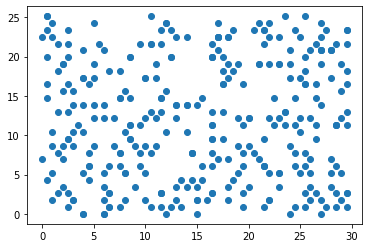

In [177]:
prj=np.array(net.project(np.array(dataframe)))
plt.scatter(prj.T[0],prj.T[1])
plt.show()

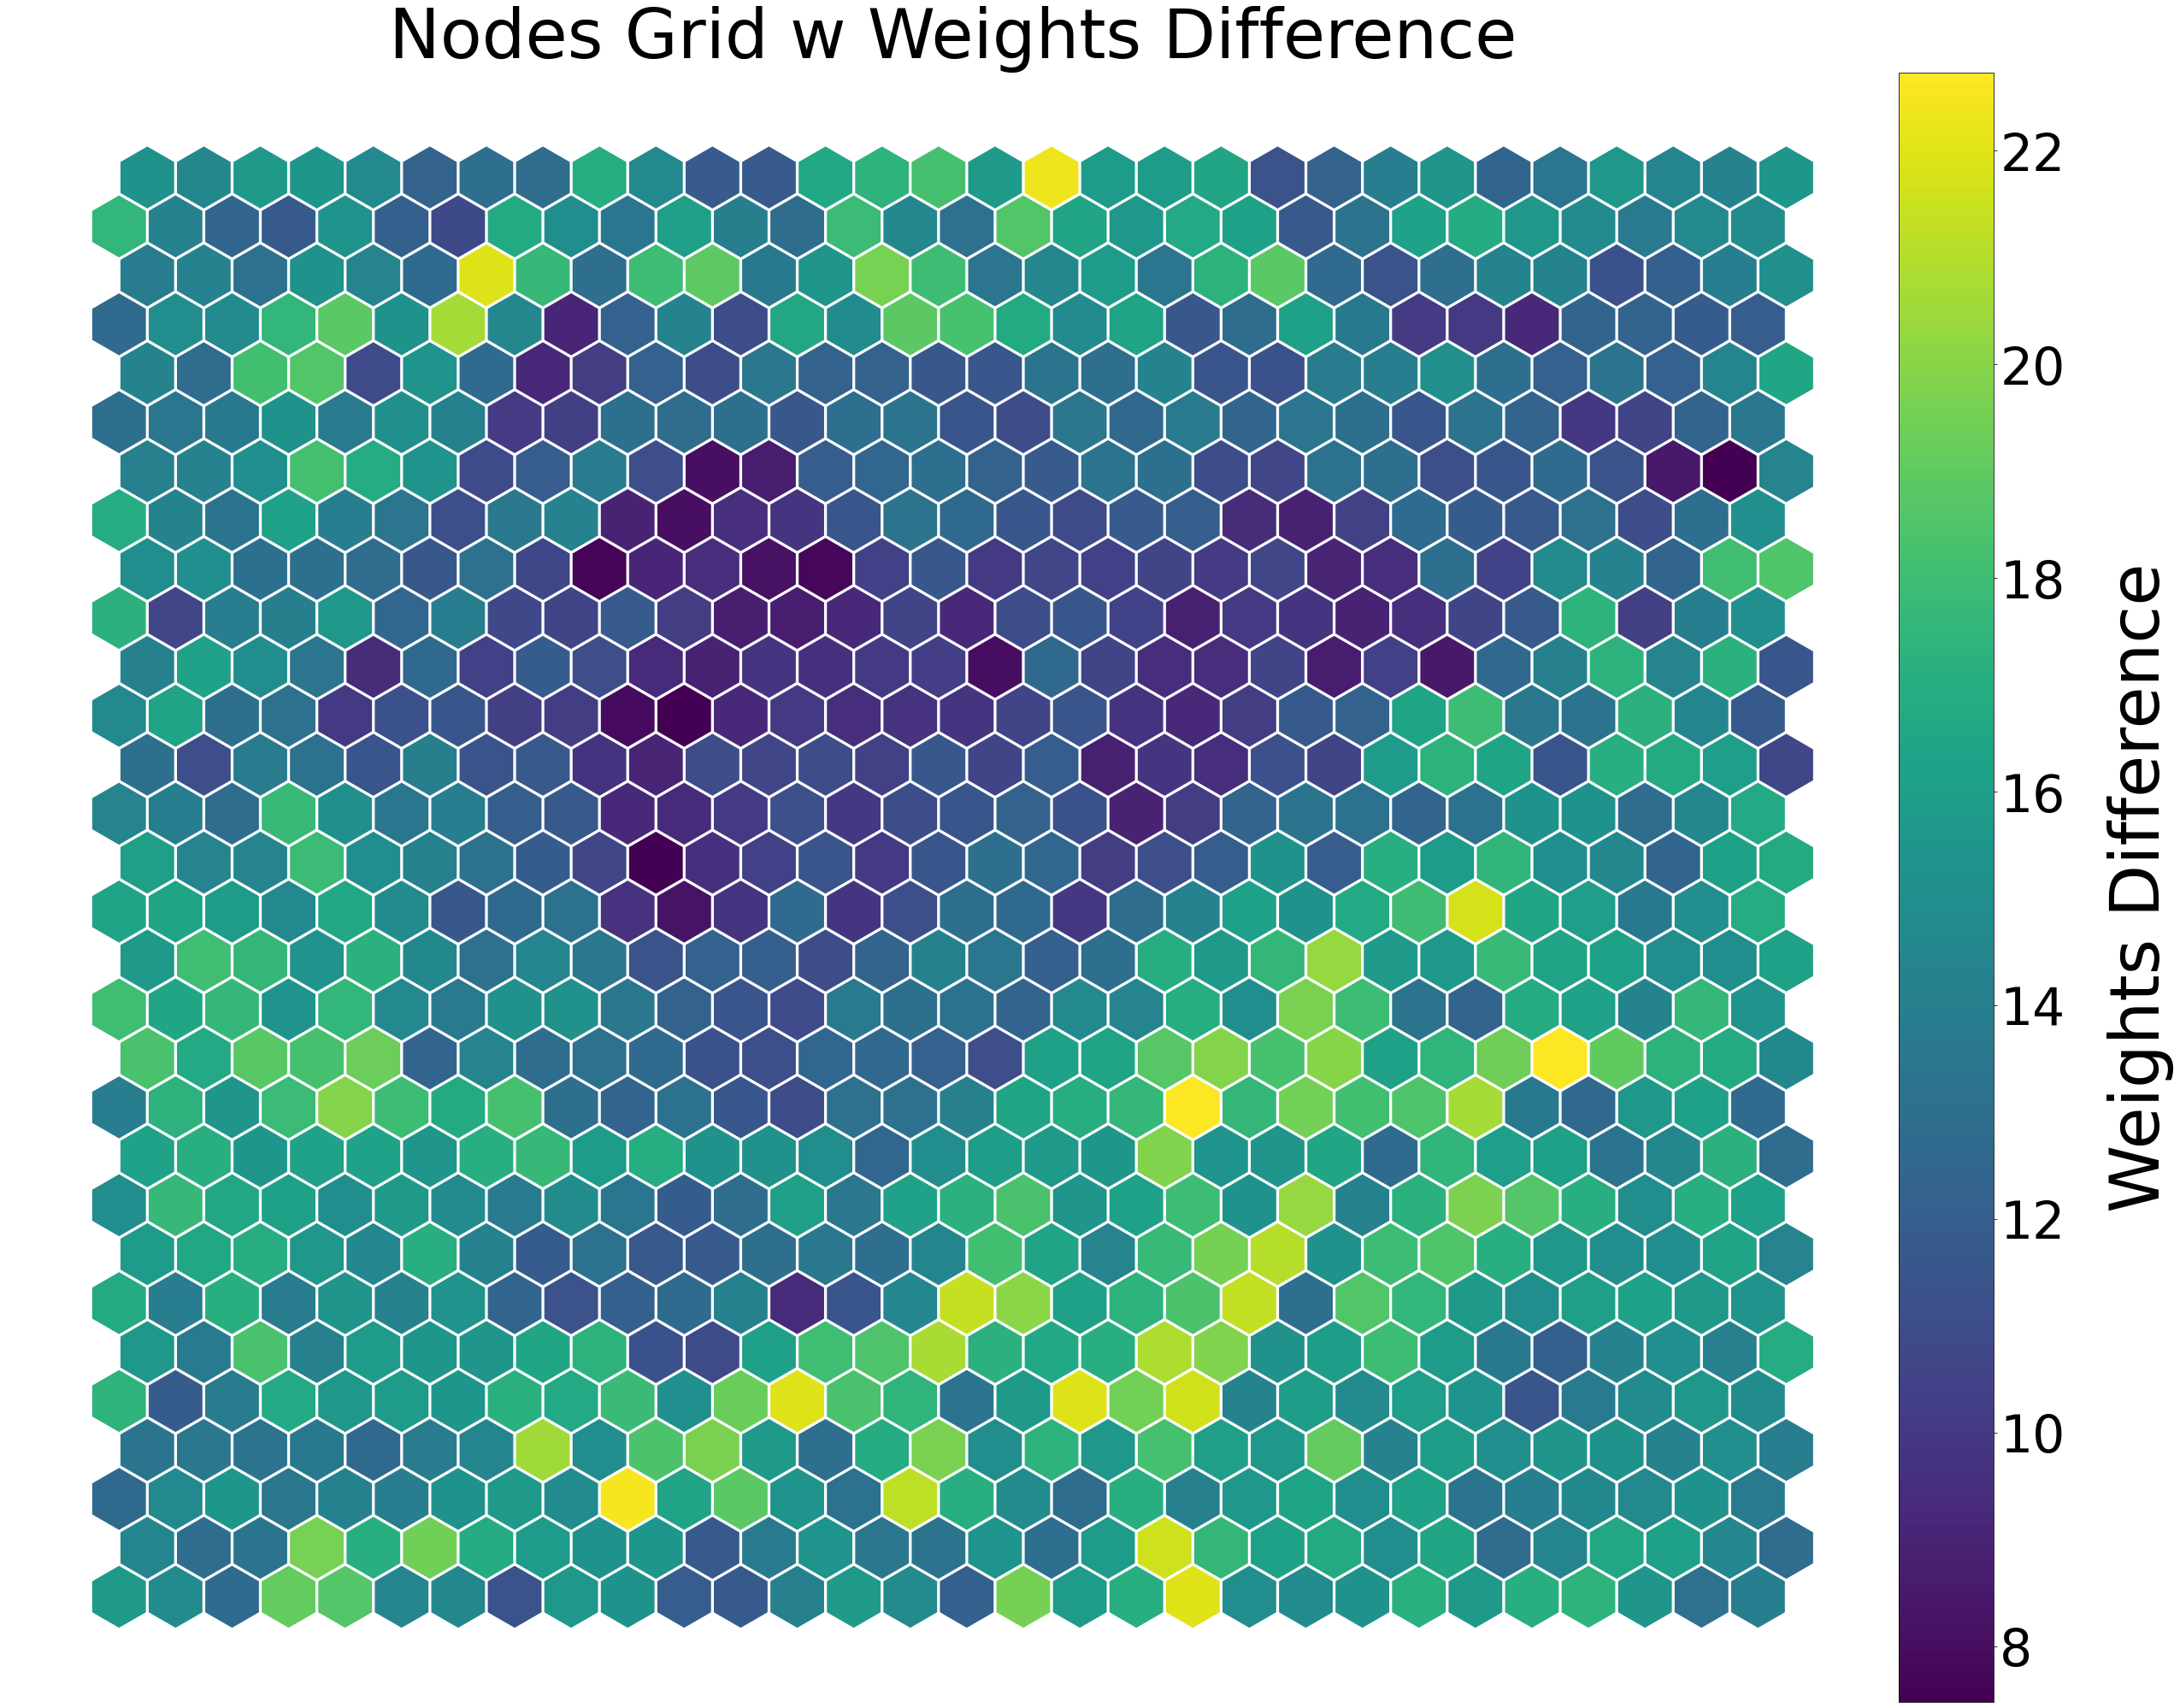

In [298]:
net.diff_graph()

In [303]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(prj)
philr["clusters"]=kmeans.labels_

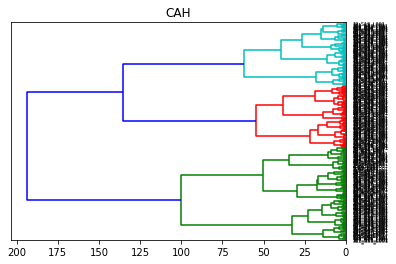

In [178]:
prj=pd.DataFrame(prj,index=dataframe.index)
d=classification_automatique(prj)
#utilisation de la methode de classification, il faut utiliser le decoupage_hauteur afin de definir les groupes 
e=d.CAH(decoupage_hauteur=125,color_threshold=125)

In [304]:
philr

n1        n2        n3         n4        n5         n6  \
echantillon                                                                  
100_S48_L001  0.790438 -0.878682  2.468779  -1.975264  1.599096  -5.739855   
101_S49_L001  1.651241  9.833018  2.599365  -0.162871  0.682568  -5.086754   
102_S50_L001  1.157778 -4.327270 -0.309271   0.355298 -1.394794  -0.512157   
103_S51_L001 -1.213039 -4.706081 -0.411300   8.182870  2.144068  -4.625343   
104_S52_L001  1.425356  0.913210  1.008803   0.850135  2.000422  -1.940007   
...                ...       ...       ...        ...       ...        ...   
96_S44_L001  -2.111836  4.201138  0.639869   7.761919  0.517263   5.821145   
97_S45_L001   1.008117 -8.876938  2.388666  -8.483913 -2.057730  13.510969   
98_S46_L001   1.223194  4.796690 -0.438901   0.277354  1.845694  -2.605190   
99_S47_L001  -0.365734 -3.541878  0.620308  -4.197587 -3.232684  -3.899464   
9_S9_L001    -0.390527 -0.755708 -1.508483  20.097173 -3.333881  17.121834   

                    n7        n8        n9        n10  ...       n53  \
echantillon                                            ...             
100_S48_L001  0.090231  0.154879 -0.200750  -5.542892  ...  2.746036   
101_S49_L001  0.383782 -0.429692 -0.111404  -3.650241  ...  2.897648   
102_S50_L001 -0.303467 -1.328532 -0.002605  -3.328718  ...  0.510885   
103_S51_L001  0.152122 -1.742045 -0.035822  -3.099414  ...  0.867084   
104_S52_L001  0.366938 -2.089069 -0.601232  -2.969624  ...  2.129526   
...                ...       ...       ...        ...  ...       ...   
96_S44_L001   0.176847 -0.270391  0.285682  -7.716488  ... -3.788508   
97_S45_L001  -0.015985  2.511683  0.284629  13.746915  ...  1.399799   
98_S46_L001  -0.178060 -1.150852 -0.048697  -0.229945  ...  3.030114   
99_S47_L001   0.193056 -0.740553  0.296370  -0.787187  ...  2.910118   
9_S9_L001     0.315247  2.960355  0.298576  -0.143171  ... -1.552042   

                   n54       n55       n56       n57       n58       n59  \
echantillon                                                                
100_S48_L001  0.234619  0.347651  3.062300  0.533585 -0.460579 -0.102754   
101_S49_L001  0.097194  0.074283  2.128239  0.701381 -1.043547  0.173497   
102_S50_L001 -0.168249 -0.411879 -3.212466 -0.247614 -1.020252 -0.780922   
103_S51_L001  0.001421 -0.101128 -0.482413  0.476310 -0.518306 -1.852548   
104_S52_L001  0.060065  0.006280  1.196583  0.627283  0.613314 -1.167133   
...                ...       ...       ...       ...       ...       ...   
96_S44_L001  -0.720110 -1.422618  1.218696  0.329131 -0.892782  0.195941   
97_S45_L001  -0.032972 -0.164117  0.069459 -0.247747  0.518864  0.850088   
98_S46_L001   0.175292  0.217320 -2.907395 -0.109381  0.857172 -0.771904   
99_S47_L001   0.142310  0.156912  1.502150  0.626300 -1.446978 -1.006676   
9_S9_L001     0.255251  0.363766  1.605668 -0.109003  0.978209  1.135828   

                   n60       n61  clusters  
echantillon                                 
100_S48_L001 -2.054185 -0.368041         1  
101_S49_L001 -1.333384 -0.351669         1  
102_S50_L001  2.378116  0.500515         2  
103_S51_L001  0.247355  0.484214         2  
104_S52_L001  0.258040  0.147074         2  
...                ...       ...       ...  
96_S44_L001   1.442197  0.045411         2  
97_S45_L001   0.068704 -0.368041         0  
98_S46_L001  -2.001417  0.541105         1  
99_S47_L001  -1.714824  0.281322         1  
9_S9_L001    -0.298147  0.359595         0  

[356 rows x 62 columns]

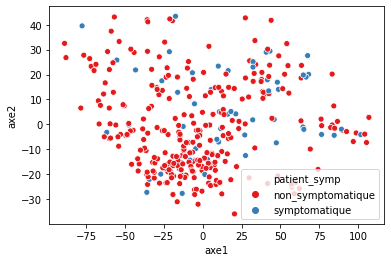

In [168]:
#importation des différent table de donnée ainsi que des espaces latents correspondant a la sortie du script auto_encodeur 

otu=pd.read_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\otu.csv")
philr=pd.read_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\DeepMicro\\philrs.csv")

metadata=pd.read_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\DeepMicro\\data\\metadata.csv")
metadata["patient_symp"]= metadata["hb"].map(lambda x: "symptomatique" if x >=5 else "non_symptomatique")
label="patient_symp"
table_philr=pd.read_csv("C:\\Users\\franc\\Documents\\stage\\DeepMicro\\DeepMicro\\results\\DAE[40-32]_philrs_rep.csv",header=None)
table_philr.set_index(otu["Unnamed: 0"],inplace=True )
table_philr.index.name="echantillon"
table_philr.reset_index(inplace=True)
table_philr=pd.merge(metadata[["echantillon"]],table_philr,on="echantillon")
table_philr.set_index("echantillon",inplace=True)
table_phil=table_philr.copy()



#metadata["nbre_medicament"]=metadata.apply(count_medicament,axis=1)
#metadata["nbre_medicament"]=metadata["nbre_medicament"].apply(lambda x: 1 if x>=1 else 0)
#print(metadata[label].value_counts())

a=reduction_de_dimension(Isomap,nbre_dimension=2)
a.mise_en_place(table_philr,metadata)
a.plot(label=label)


In [74]:
# utilisation des arbre décisitionnel afin de quantifier l'impacte des métadata sur les groupes trouvé dans un permier temps on va commencer par tester sur les otu et les groupe en utilisant la classe choisi 
# premierement je vais m'initier a cette méthode 
#importation des library
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
#division du jeu d'apprantissage de train et de test, pour cela on passe le tableau otu en xtrain et les trois valeur en train
y=data["groupe_cah"]
x=data.iloc[:,1:135]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
clf = DecisionTreeClassifier(criterion="entropy", max_depth=1000)
clf = clf.fit(X_train,y_train)


In [75]:
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8615384615384616


In [22]:
data2 = data2.astype('category')
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
for i in data2.columns:
    try:
        data2[i] = data2[i].apply(lambda col: le.fit_transform(col))
    except:
        pass
data=pd.get_dummies(data2)
data.astype(float)
import xgboost as xgb


dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

params = {
    'max_depth': 6,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 4,
    'n_gpus': 0
}
bst = xgb.train(params, dtrain)
pred = bst.predict(dtest)

from sklearn.metrics import classification_report

print(classification_report(y_test, pred))


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
cm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        plt.savefig('confusion-matrix.png')

plot_confusion_matrix(cm, ['producer 1', 'producer 2', 'producer 3'])

micianteriorite_chir_1_0  \
echantillon                              
21_S21_L001                        0.0   
309_S1_L001                        0.0   
159_S43_L001                       0.0   
127_S11_L001                       0.0   
6_S6_L001                          0.0   
...                                ...   
106_S54_L001                       0.0   
251_S7_L001                        0.0   
218_S38_L001                       0.0   
328_S20_L001                       0.0   
258_S14_L001                       0.0   

              micianteriorite_chir_1_1_ileocolectomie  \
echantillon                                             
21_S21_L001                                       0.0   
309_S1_L001                                       0.0   
159_S43_L001                                      0.0   
127_S11_L001                                      0.0   
6_S6_L001                                         0.0   
...                                               ...   
106_S54_L001                                      0.0   
251_S7_L001                                       0.0   
218_S38_L001                                      0.0   
328_S20_L001                                      0.0   
258_S14_L001                                      0.0   

              micianteriorite_chir_1_2_resection_grele  \
echantillon                                              
21_S21_L001                                        0.0   
309_S1_L001                                        0.0   
159_S43_L001                                       0.0   
127_S11_L001                                       0.0   
6_S6_L001                                          0.0   
...                                                ...   
106_S54_L001                                       0.0   
251_S7_L001                                        0.0   
218_S38_L001                                       0.0   
328_S20_L001                                       0.0   
258_S14_L001                                       0.0   

              micianteriorite_chir_1_6_chirurgie_perineale  \
echantillon                                                  
21_S21_L001                                            0.0   
309_S1_L001                                            0.0   
159_S43_L001                                           0.0   
127_S11_L001                                           1.0   
6_S6_L001                                              0.0   
...                                                    ...   
106_S54_L001                                           0.0   
251_S7_L001                                            0.0   
218_S38_L001                                           0.0   
328_S20_L001                                           0.0   
258_S14_L001                                           0.0   

              micianteriorite_chir_1_Mise_à_la_peau_en,_stomie_d'une_perforation_iléale  \
echantillon                                                                               
21_S21_L001                                                 0.0                           
309_S1_L001                                                 0.0                           
159_S43_L001                                                0.0                           
127_S11_L001                                                0.0                           
6_S6_L001                                                   0.0                           
...                                                         ...                           
106_S54_L001                                                0.0                           
251_S7_L001                                                 0.0                           
218_S38_L001                                                0.0                           
328_S20_L001                                                0.0                           
258_S14_L001                                                0.0        

              precision    recall  f1-score   support

           1       0.90      1.00      0.95        28
           2       0.94      0.94      0.94        18
           3       0.94      0.79      0.86        19

    accuracy                           0.92        65
   macro avg       0.93      0.91      0.92        65
weighted avg       0.92      0.92      0.92        65



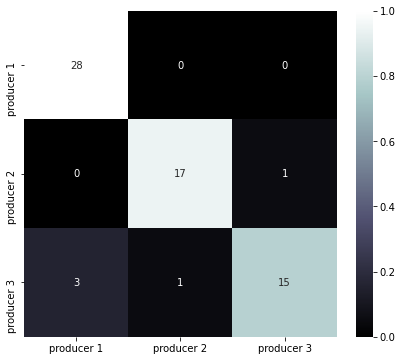

In [79]:
import xgboost as xgb


dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

params = {
    'max_depth': 6,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 4,
    'n_gpus': 0
}
bst = xgb.train(params, dtrain)
pred = bst.predict(dtest)

from sklearn.metrics import classification_report

print(classification_report(y_test, pred))


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
cm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        plt.savefig('confusion-matrix.png')

plot_confusion_matrix(cm, ['producer 1', 'producer 2', 'producer 3'])

In [152]:
columns = data.columns.tolist()

# Filtrer les colonnes pour supprimer celles que nous ne voulons pas.
columns_cat = [c for c in columns if data[c].dtypes == "object" ]
columns_int = [c for c in columns if data[c].dtypes == "int64" ]
columns = [c.astype("category") for c in columns if (data[c].dtypes == "float")&(len(data[c].value_counts().index.tolist())<5)]
columns_cat
columns_int

AttributeError: 'str' object has no attribute 'astype'